In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os, sys
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from sklearn.preprocessing import MinMaxScaler



# IMPORT DATA

In [2]:
df_30_strat1 = pd.read_csv('./df_30_strat1.csv')
df_15_strat2 = pd.read_csv('./df_15_strat2.csv')
df_15_strat4 = pd.read_csv('./df_15_strat4.csv')


# EDA Cleaning check

In [3]:
df_30_strat1.isna().sum()

datetime     0
ticker_id    0
open         0
high         0
low          0
close        0
volume       0
psarl        0
psars        0
psaraf       0
psarr        0
macd         0
macdh        0
macds        0
ema_200      0
dtype: int64

In [4]:
df_30_strat1.dtypes

datetime      object
ticker_id     object
open         float64
high         float64
low          float64
close        float64
volume       float64
psarl        float64
psars        float64
psaraf       float64
psarr        float64
macd         float64
macdh        float64
macds        float64
ema_200      float64
dtype: object

In [5]:
df_15_strat2.isna().sum()

datetime       0
ticker_id      0
open           0
high           0
low            0
close          0
volume         0
supert         0
supertd        0
supertl        0
superts        0
rsi_14         0
rsi_14_a_70    0
rsi_14_b_30    0
ema_200        0
dtype: int64

In [6]:
df_15_strat2.dtypes

datetime        object
ticker_id       object
open           float64
high           float64
low            float64
close          float64
volume         float64
supert         float64
supertd        float64
supertl        float64
superts        float64
rsi_14         float64
rsi_14_a_70    float64
rsi_14_b_30    float64
ema_200        float64
dtype: object

# DF 30 Strat1 30 min model

## Reformating Model Data

In [7]:
def get_column_format(df):
  datetime = df['datetime'].iloc[0]
  temp = df[['ticker_id', 'open', 'high', 'low', 'close', 'volume', 'psarl', 'psars', 'psarr', 'psaraf', 'macd', 'macdh', 'macds', 'ema_200']]
  
  ans = []
  for i, r in temp.iterrows():
    ticker = r['ticker_id']
    temp = {'datetime': datetime, 'ticker_id': ticker}
    for curr_col in ['ticker_id', 'open', 'high', 'low', 'close', 'volume', 'psarl', 'psars', 'psarr', 'psaraf', 'macd', 'macdh', 'macds', 'ema_200']:
      temp[f"{curr_col}_{ticker}"] = [r[curr_col]]
    del temp['ticker_id']
    ans.append(temp)
  ans = {k: v for d in ans for k, v in d.items()}
  return pd.DataFrame(ans)


def make_X_y_df(df_time):
  master_df = pd.DataFrame()
  datetime_unq = df_time['datetime'].unique()
  for datetime in datetime_unq:
    df = df_time[df_time['datetime'] == datetime] 
    master_df = pd.concat([master_df, get_column_format(df)], axis=0)
  return master_df
      
def get_columns_that_startwith(df, col_str):
  return df[df.columns[pd.Series(df.columns).str.contains(col_str)]]


## Feature Engineering

In [8]:
df_30_strat1 = make_X_y_df(df_30_strat1)
df_30_strat1.set_index('datetime', inplace = True)

In [9]:
df_30_strat1.drop(columns=list(get_columns_that_startwith(df_30_strat1, 'ticker_id').columns), inplace=True)

In [10]:
column_indices = {name: i for i, name in enumerate(df_30_strat1.columns)}
column_indices = [column_indices.get(k) for k in ['close_ADABTC', 'close_ONEBTC', 'close_HBARBTC', 'close_VETBTC', 'close_LTCBTC', 'close_BCHBTC', 'close_ETHBTC']]
column_indices

[42, 16, 68, 81, 55, 3, 29]

In [11]:
train_index = round(df_30_strat1.shape[0] * .8)
validation_index = round(df_30_strat1.shape[0] * .1)
test_index = round(df_30_strat1.shape[0] * .1)
train_index, validation_index, test_index

(455, 57, 57)

In [12]:
train_df = df_30_strat1.iloc[:train_index]
val_df = df_30_strat1.iloc[train_index:(train_index+validation_index)]
test_df = df_30_strat1[(train_index+validation_index):(train_index+validation_index+test_index)]
train_df.shape, val_df.shape, test_df.shape

((455, 91), (57, 91), (57, 91))

In [13]:
X = pd.concat([get_columns_that_startwith(df_30_strat1, 'open'), get_columns_that_startwith(df_30_strat1, 'high'), 
               get_columns_that_startwith(df_30_strat1, 'low'), get_columns_that_startwith(df_30_strat1, 'close'),
               get_columns_that_startwith(df_30_strat1, 'volume'), get_columns_that_startwith(df_30_strat1, 'psarl'),
               get_columns_that_startwith(df_30_strat1, 'psars'), get_columns_that_startwith(df_30_strat1, 'psaraf'),
               get_columns_that_startwith(df_30_strat1, 'psarr'), get_columns_that_startwith(df_30_strat1, 'macd'),
               get_columns_that_startwith(df_30_strat1, 'macdh'), get_columns_that_startwith(df_30_strat1, 'macds'), 
               get_columns_that_startwith(df_30_strat1, 'ema_200')], axis = 1)
y = get_columns_that_startwith(df_30_strat1, 'close')


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

## Scale

In [15]:
sc = MinMaxScaler(feature_range=(0,1))
train_df_scal = pd.DataFrame(sc.fit_transform(train_df), columns=train_df.columns)
val_df_scal = pd.DataFrame(sc.transform(val_df), columns=val_df.columns)

## Window gen

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_scal, val_df=val_df_scal, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [18]:
def plot(self, model=None, plot_col='', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  plt.subplot(1, 1, 1)
  plt.ylabel(f'{plot_col}')
  plt.plot(self.input_indices, inputs[1, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)
  if self.label_columns:
    label_col_index = self.label_columns_indices.get(plot_col, None)
  else:
    label_col_index = plot_col_index

  plt.scatter(self.label_indices, labels[1, :, label_col_index],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
  if model is not None:
    predictions = model(inputs)
    plt.scatter(self.label_indices, predictions[1, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
  plt.legend()
  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [22]:
column_indices

[42, 16, 68, 81, 55, 3, 29]

In [23]:
baseline = Baseline(label_index=tf.cast(column_indices, tf.int32))

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
# val_performance['baseline'] = baseline.evaluate(single_step_window.val)
# performance['baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


In [24]:
wide_window = WindowGenerator(
    input_width=8, label_width=8, shift=3,
    label_columns=list(y.columns))

wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 3  4  5  6  7  8  9 10]
Label column name(s): ['close_BCHBTC', 'close_ONEBTC', 'close_ETHBTC', 'close_ADABTC', 'close_LTCBTC', 'close_HBARBTC', 'close_VETBTC']

In [25]:
single_step_window = WindowGenerator(
    input_width=3, label_width=3, shift=3,
    label_columns=list(y.columns))
single_step_window

Total window size: 6
Input indices: [0 1 2]
Label indices: [3 4 5]
Label column name(s): ['close_BCHBTC', 'close_ONEBTC', 'close_ETHBTC', 'close_ADABTC', 'close_LTCBTC', 'close_HBARBTC', 'close_VETBTC']

## Basic Model Testing

In [26]:
def compile_and_fit(model, window, patience=7, MAX_EPOCHS = 200, optimizer=tf.keras.optimizers.Adam()):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# tf.keras.optimizers.Adam()
# tf.optimizers.RMSprop()


### Model 0

In [27]:
model0 = Sequential()
model0.add(LSTM(units=256, return_sequences=True))
model0.add(Dense(units=7))
history = compile_and_fit(model0, single_step_window)

Epoch 1/200
15/15 [==============================] - 7s 34ms/step - loss: 0.0797 - mean_absolute_error: 0.2185 - val_loss: 0.0578 - val_mean_absolute_error: 0.1881
Epoch 2/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0264 - mean_absolute_error: 0.1255 - val_loss: 0.0522 - val_mean_absolute_error: 0.1745
Epoch 3/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0145 - mean_absolute_error: 0.0938 - val_loss: 0.0402 - val_mean_absolute_error: 0.1549
Epoch 4/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0115 - mean_absolute_error: 0.0833 - val_loss: 0.0369 - val_mean_absolute_error: 0.1458
Epoch 5/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0102 - mean_absolute_error: 0.0781 - val_loss: 0.0352 - val_mean_absolute_error: 0.1404
Epoch 6/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.0760 - val_loss: 0.0322 - val_mean_absolute_error: 0.1351
Epoch 7/200
15/15 [==

2/2 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_absolute_error: 0.0956


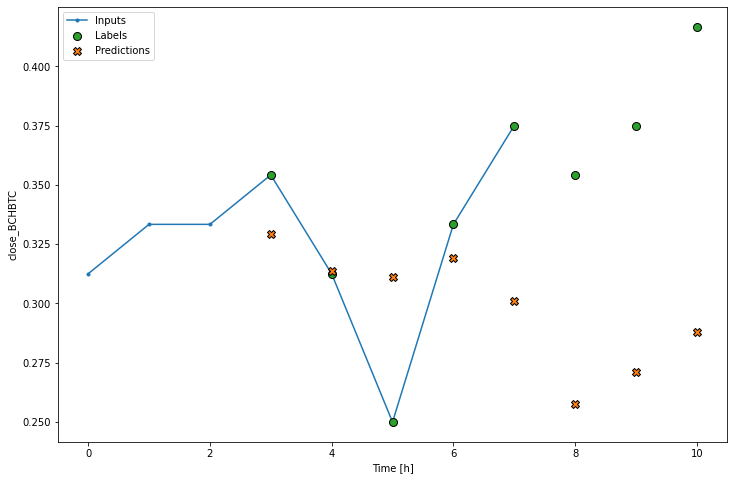

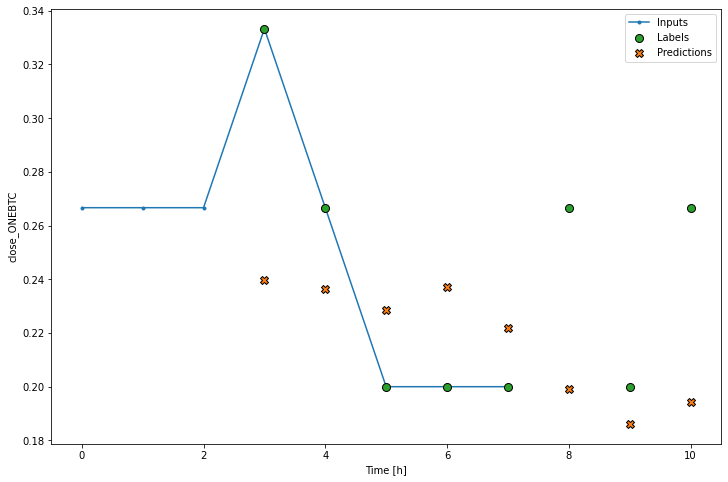

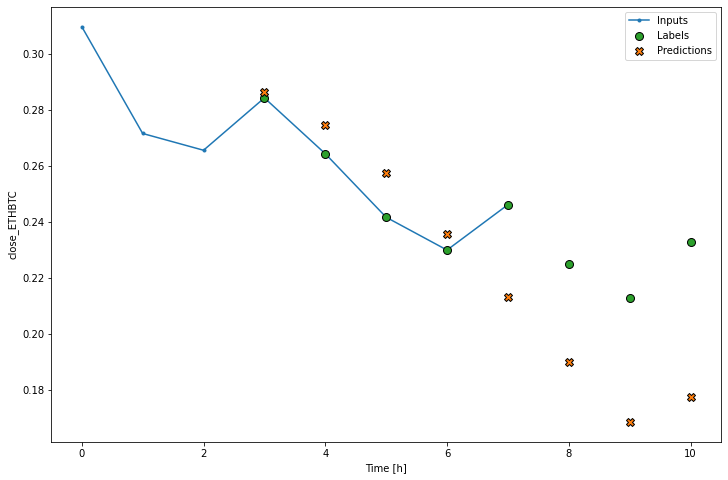

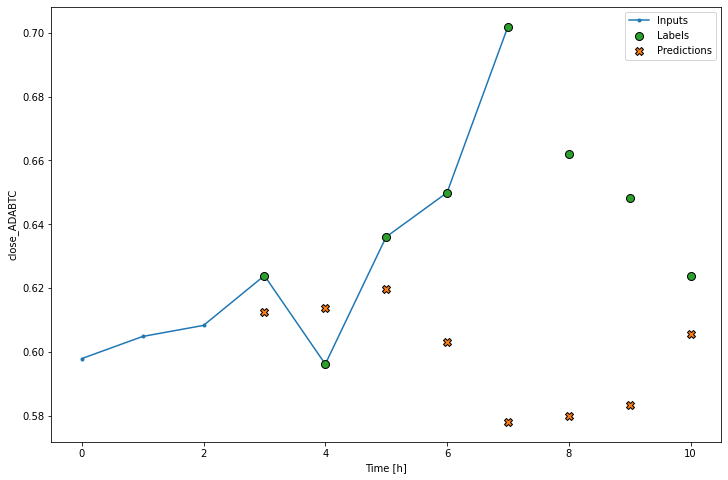

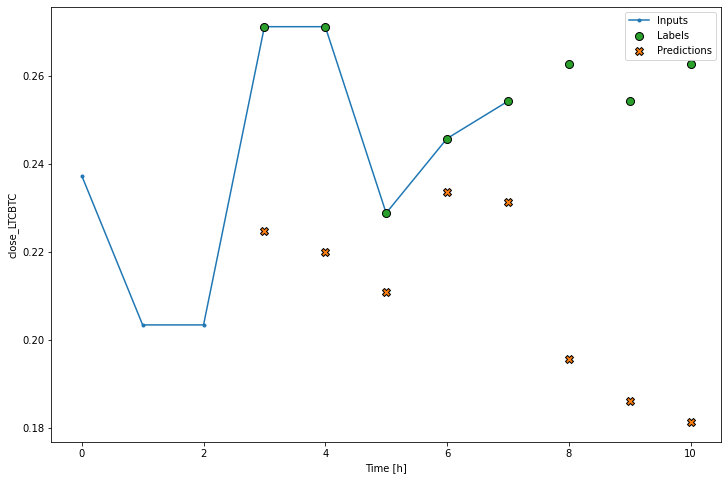

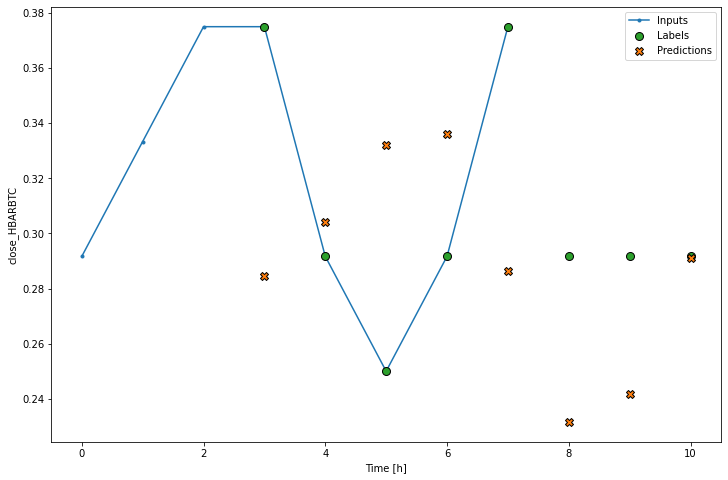

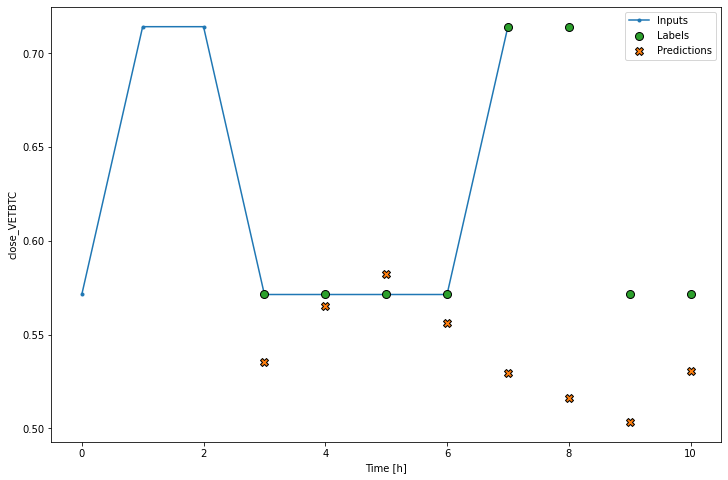

In [28]:
val_performance['model0'] = model0.evaluate(single_step_window.val)
performance['model0'] = model0.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model0, plot_col=i)

### Model 1

In [29]:
model1 = Sequential()
model1.add(SimpleRNN(256, return_sequences=True))
model1.add(Dense(units=7))
history1 = compile_and_fit(model1, single_step_window)

Epoch 1/200
15/15 [==============================] - 1s 19ms/step - loss: 0.1845 - mean_absolute_error: 0.3006 - val_loss: 0.0599 - val_mean_absolute_error: 0.2017
Epoch 2/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0442 - mean_absolute_error: 0.1620 - val_loss: 0.0311 - val_mean_absolute_error: 0.1441
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: 0.0213 - mean_absolute_error: 0.1134 - val_loss: 0.0324 - val_mean_absolute_error: 0.1416
Epoch 4/200
15/15 [==============================] - 0s 8ms/step - loss: 0.0148 - mean_absolute_error: 0.0946 - val_loss: 0.0322 - val_mean_absolute_error: 0.1468
Epoch 5/200
15/15 [==============================] - 0s 8ms/step - loss: 0.0141 - mean_absolute_error: 0.0927 - val_loss: 0.0200 - val_mean_absolute_error: 0.1113
Epoch 6/200
15/15 [==============================] - 0s 8ms/step - loss: 0.0108 - mean_absolute_error: 0.0802 - val_loss: 0.0223 - val_mean_absolute_error: 0.1210
Epoch 7/200
15/15 [==

2/2 [==============================] - 0s 4ms/step - loss: 0.0171 - mean_absolute_error: 0.1044


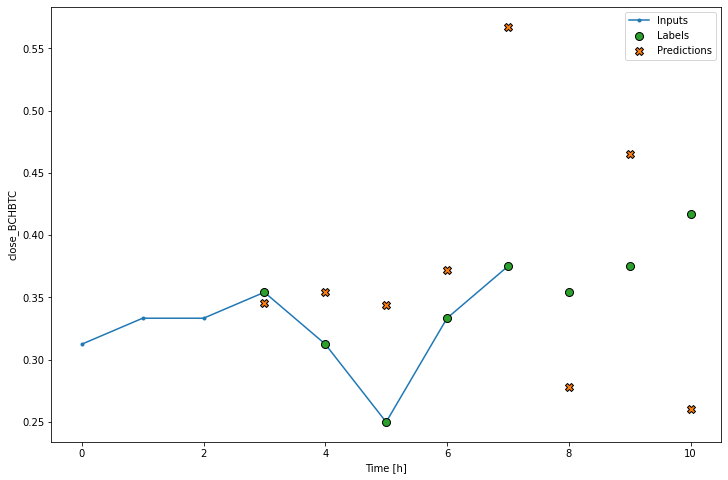

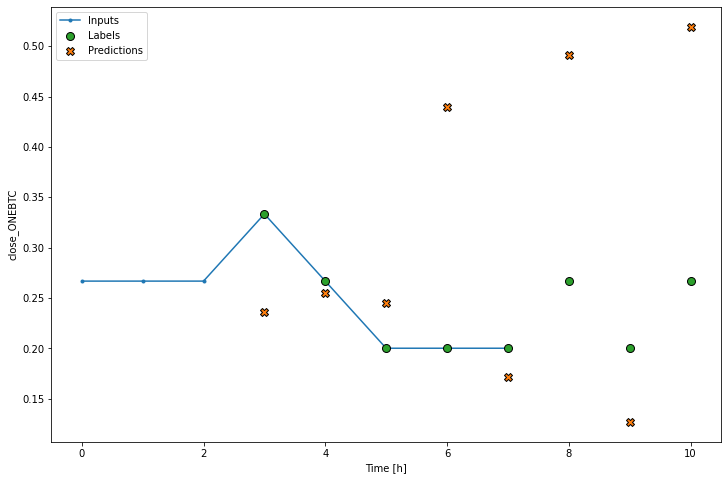

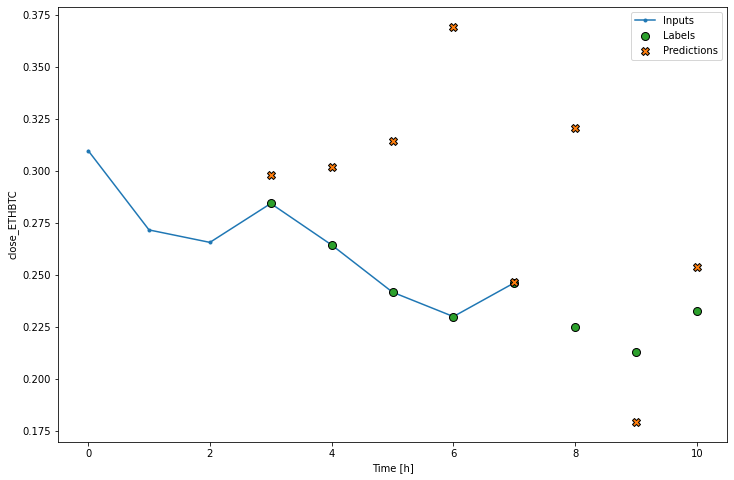

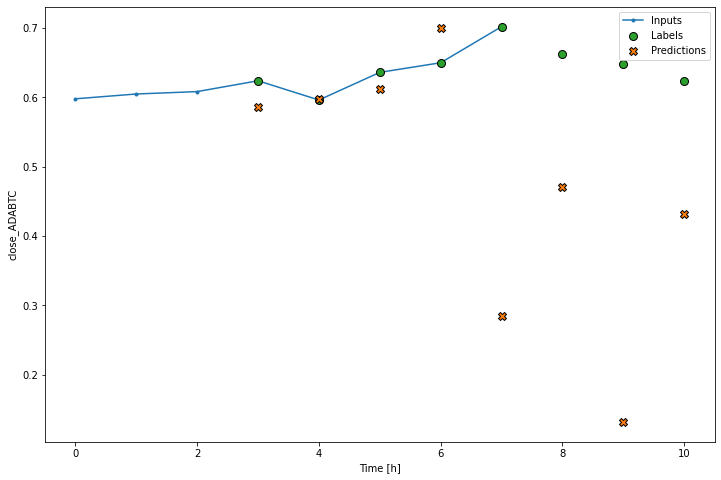

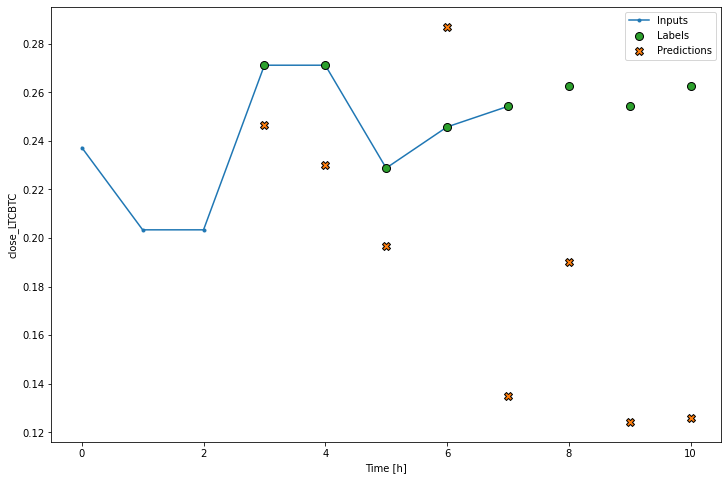

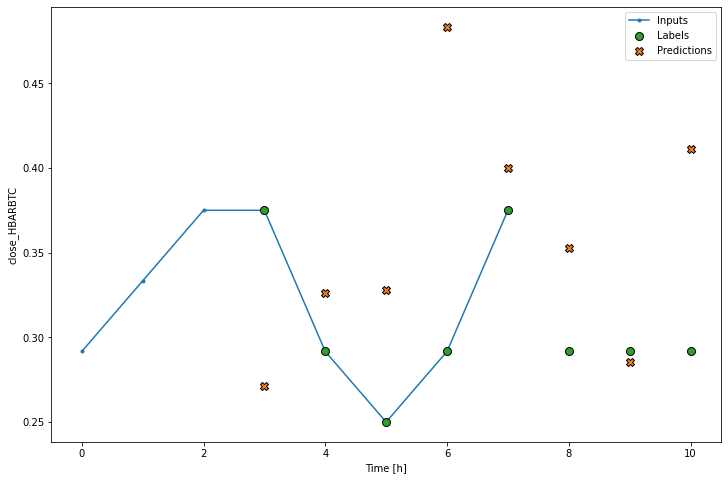

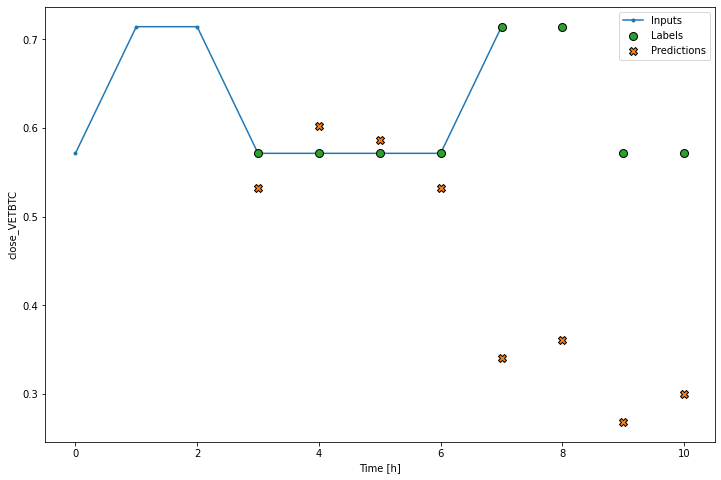

In [30]:
val_performance['model1'] = model1.evaluate(single_step_window.val)
performance['model1'] = model1.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model1, plot_col=i)

### Model 2:

In [31]:
model2 = Sequential()
model2.add(GRU(units=256, return_sequences=True))
model2.add(Dense(units=7))
history1 = compile_and_fit(model2, single_step_window)

Epoch 1/200
15/15 [==============================] - 2s 29ms/step - loss: 0.0849 - mean_absolute_error: 0.2117 - val_loss: 0.0426 - val_mean_absolute_error: 0.1760
Epoch 2/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0175 - mean_absolute_error: 0.1012 - val_loss: 0.0276 - val_mean_absolute_error: 0.1290
Epoch 3/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0111 - mean_absolute_error: 0.0819 - val_loss: 0.0311 - val_mean_absolute_error: 0.1295
Epoch 4/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0751 - val_loss: 0.0305 - val_mean_absolute_error: 0.1367
Epoch 5/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0696 - val_loss: 0.0216 - val_mean_absolute_error: 0.1120
Epoch 6/200
15/15 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0682 - val_loss: 0.0191 - val_mean_absolute_error: 0.1078
Epoch 7/200
15/15 [==

2/2 [==============================] - 0s 4ms/step - loss: 0.0171 - mean_absolute_error: 0.1050


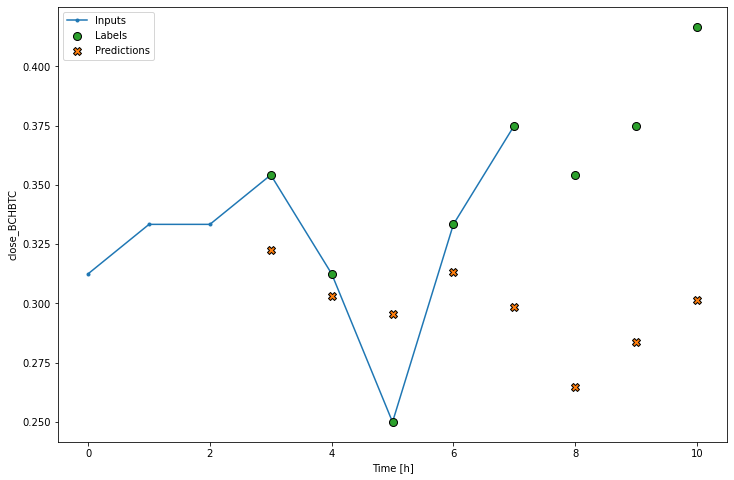

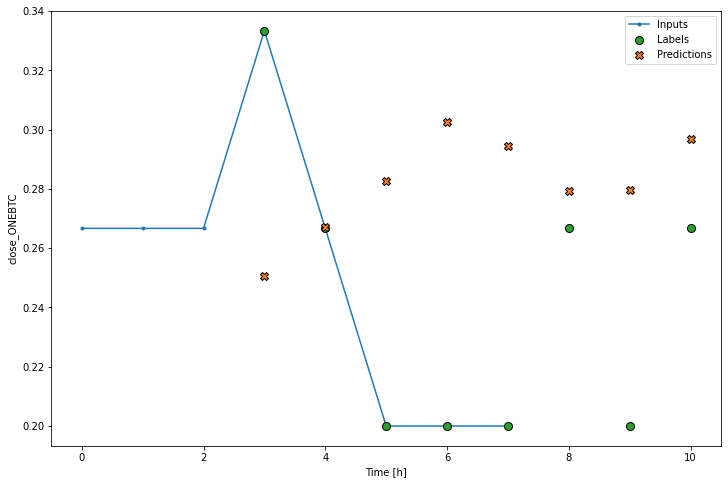

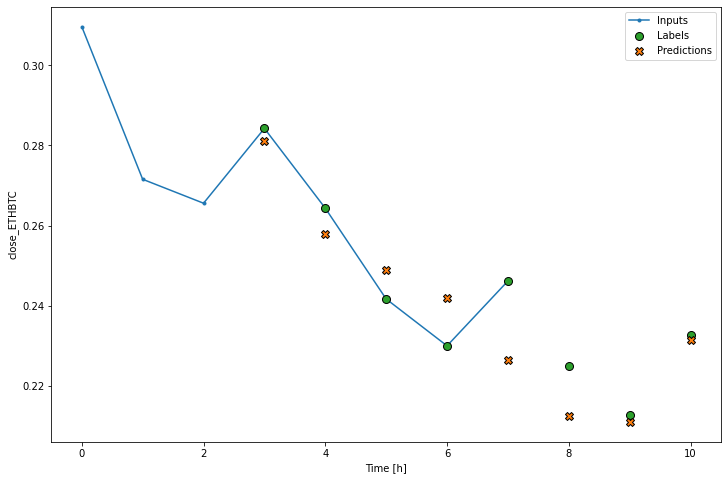

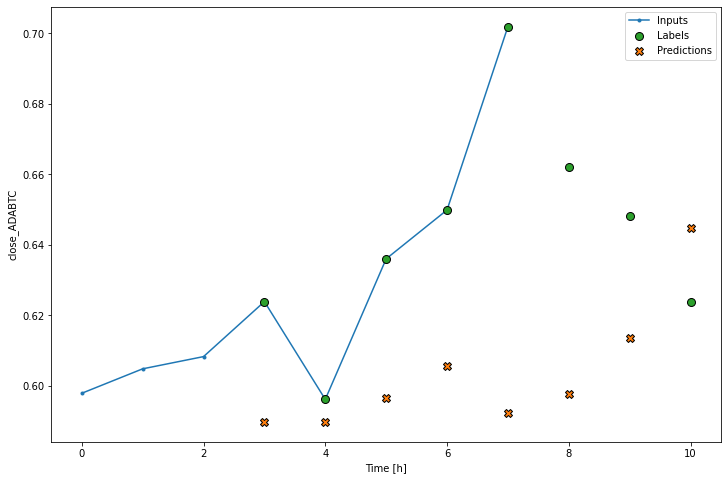

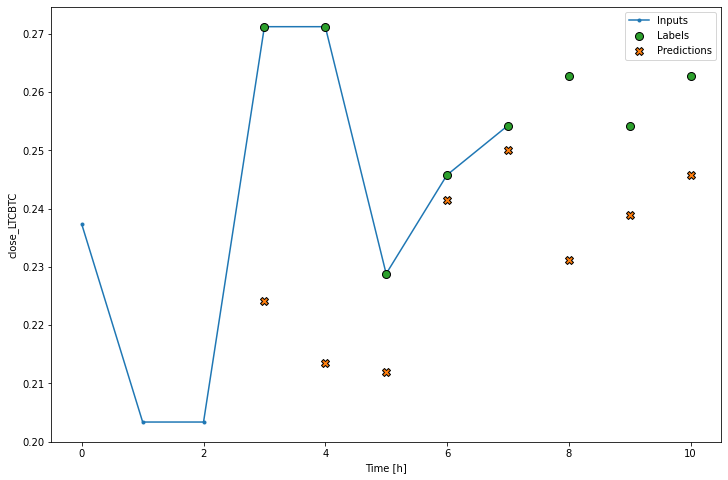

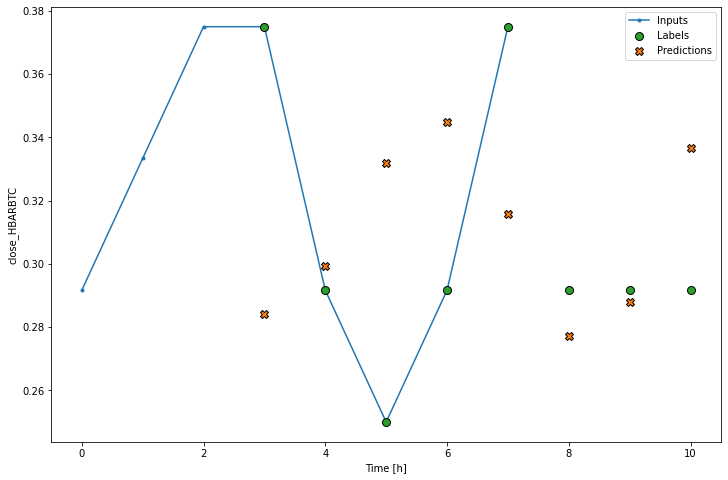

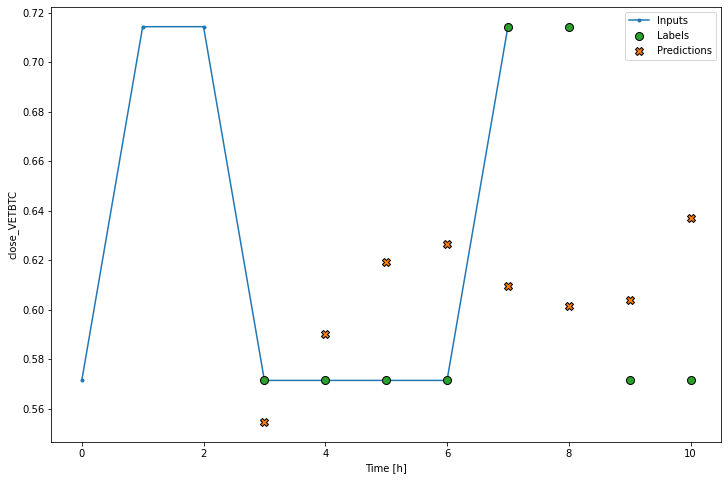

In [32]:
val_performance['model2'] = model2.evaluate(single_step_window.val)
performance['model2'] = model2.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model2, plot_col=i)

### Model 3:

In [33]:
model3 = Sequential()
model3.add(Bidirectional(layer=LSTM(units=64, return_sequences=True), backward_layer=SimpleRNN(units=64, return_sequences=True,go_backwards=True)))
model3.add(Dropout(0.3))
model3.add(Dense(units=7))
history = compile_and_fit(model3, single_step_window)

Epoch 1/200
15/15 [==============================] - 3s 40ms/step - loss: 0.2295 - mean_absolute_error: 0.3658 - val_loss: 0.0639 - val_mean_absolute_error: 0.1981
Epoch 2/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0730 - mean_absolute_error: 0.2092 - val_loss: 0.0358 - val_mean_absolute_error: 0.1510
Epoch 3/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0458 - mean_absolute_error: 0.1657 - val_loss: 0.0287 - val_mean_absolute_error: 0.1374
Epoch 4/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0327 - mean_absolute_error: 0.1400 - val_loss: 0.0283 - val_mean_absolute_error: 0.1351
Epoch 5/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0273 - mean_absolute_error: 0.1288 - val_loss: 0.0273 - val_mean_absolute_error: 0.1328
Epoch 6/200
15/15 [==============================] - 0s 9ms/step - loss: 0.0247 - mean_absolute_error: 0.1222 - val_loss: 0.0206 - val_mean_absolute_error: 0.1158
Epoch 7/200
15/15 [==

2/2 [==============================] - 0s 5ms/step - loss: 0.0143 - mean_absolute_error: 0.0922


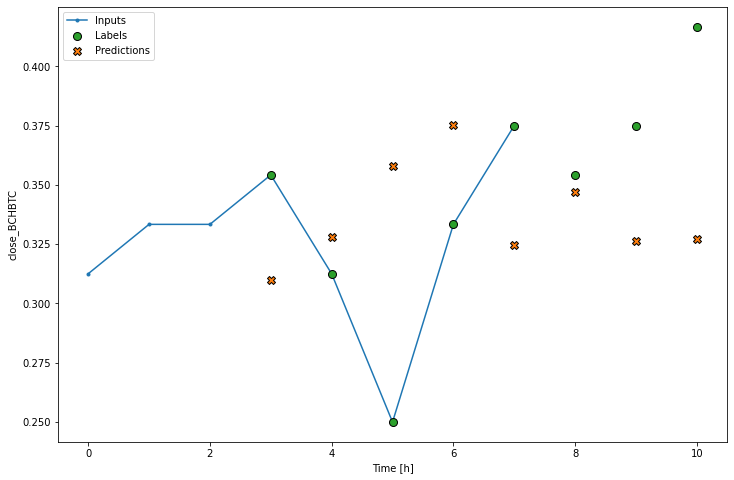

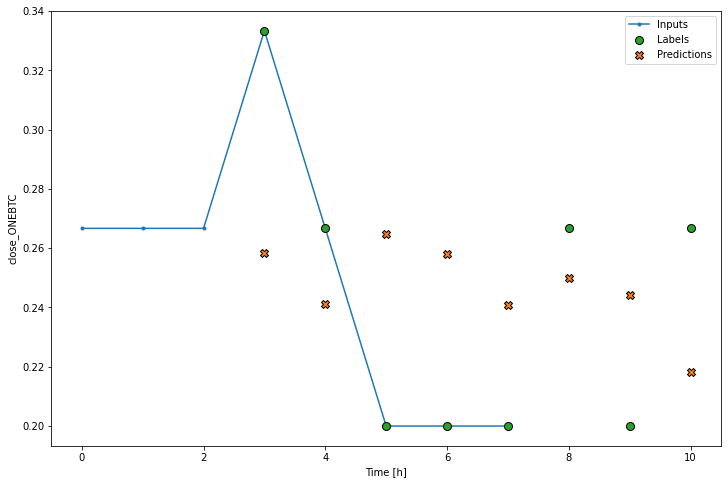

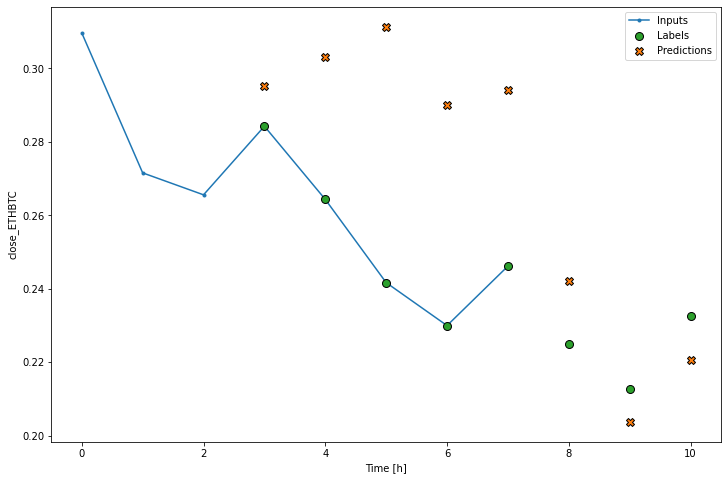

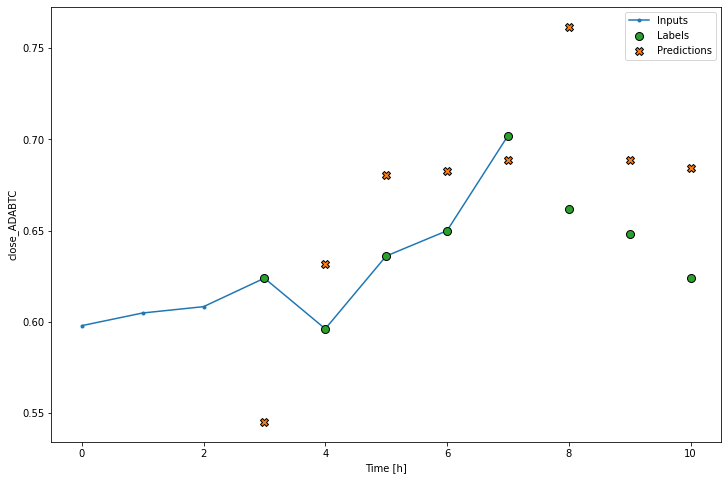

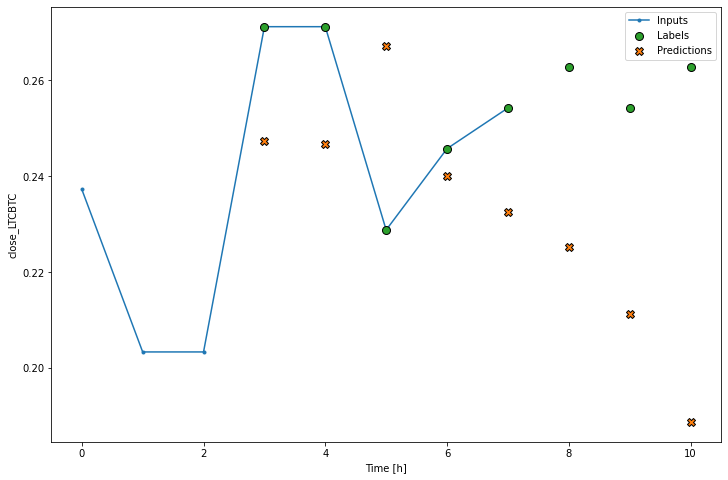

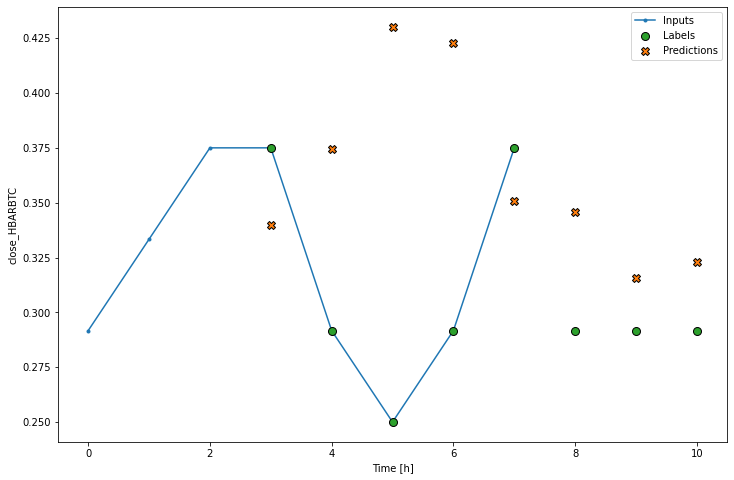

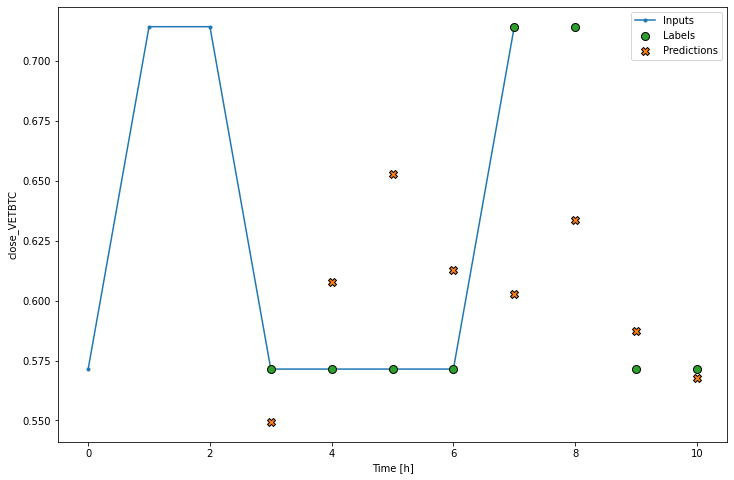

In [34]:
val_performance['model3'] = model3.evaluate(single_step_window.val)
performance['model3'] = model3.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model3, plot_col=i)

# DF 15 Strat2 15 min model

## Reformating Model Data

In [35]:
def get_column_format(df):
  datetime = df['datetime'].iloc[0]
  temp = df[['ticker_id', 'open', 'high', 'low', 'close', 'volume', 'supert', 'supertd', 'supertl', 'superts', 'rsi_14', 'rsi_14_a_70', 'rsi_14_b_30', 'ema_200']]
  
  ans = []
  for i, r in temp.iterrows():
    ticker = r['ticker_id']
    temp = {'datetime': datetime, 'ticker_id': ticker}
    for curr_col in ['ticker_id', 'open', 'high', 'low', 'close', 'volume', 'supert', 'supertd', 'supertl', 'superts', 'rsi_14', 'rsi_14_a_70', 'rsi_14_b_30', 'ema_200']:
      temp[f"{curr_col}_{ticker}"] = [r[curr_col]]
    del temp['ticker_id']
    ans.append(temp)
  ans = {k: v for d in ans for k, v in d.items()}
  return pd.DataFrame(ans)

def make_X_y_df(df_time):
  master_df = pd.DataFrame()
  datetime_unq = df_time['datetime'].unique()
  for datetime in datetime_unq:
    df = df_time[df_time['datetime'] == datetime] 
    master_df = pd.concat([master_df, get_column_format(df)], axis=0)
  return master_df
      
def get_columns_that_startwith(df, col_str):
  return df[df.columns[pd.Series(df.columns).str.contains(col_str)]]


## Feature Engineearing

In [36]:
df_15_strat2 = make_X_y_df(df_15_strat2)
df_15_strat2.set_index('datetime', inplace = True)

In [37]:
df_15_strat2.drop(columns=list(get_columns_that_startwith(df_15_strat2, 'KNCBTC').columns), inplace=True)
df_15_strat2.drop(columns=list(get_columns_that_startwith(df_15_strat2, 'USDT').columns), inplace=True)
df_15_strat2.drop(columns=list(get_columns_that_startwith(df_15_strat2, 'ticker_id').columns), inplace=True)

In [38]:
df_15_strat2.isna().sum()

open_HBARBTC           96
high_HBARBTC           96
low_HBARBTC            96
close_HBARBTC          96
volume_HBARBTC         96
                     ... 
superts_LTCBTC        384
rsi_14_LTCBTC         384
rsi_14_a_70_LTCBTC    384
rsi_14_b_30_LTCBTC    384
ema_200_LTCBTC        384
Length: 91, dtype: int64

In [39]:
df_15_strat2.dropna(axis=0, inplace=True)
df_15_strat2.sort_index(inplace=True)

In [40]:
column_indices = {name: i for i, name in enumerate(df_15_strat2.columns)}
column_indices = [column_indices.get(k) for k in ['close_ADABTC', 'close_ONEBTC', 'close_HBARBTC', 'close_VETBTC', 'close_LTCBTC', 'close_BCHBTC', 'close_ETHBTC']]
column_indices

[42, 29, 3, 16, 81, 68, 55]

In [41]:
train_index = round(df_15_strat2.shape[0] * .8)
validation_index = round(df_15_strat2.shape[0] * .1)
test_index = round(df_15_strat2.shape[0] * .1)
train_index, validation_index, test_index

(6132, 766, 766)

In [42]:
train_df = df_15_strat2.iloc[:train_index]
val_df = df_15_strat2.iloc[train_index:(train_index+validation_index)]
test_df = df_15_strat2[(train_index+validation_index):(train_index+validation_index+test_index)]
train_df.shape, val_df.shape, test_df.shape

((6132, 91), (766, 91), (766, 91))

In [43]:
y = get_columns_that_startwith(df_15_strat2, 'close')
y

close_HBARBTC  close_VETBTC  close_ONEBTC  \
datetime                                                               
2022-03-19 17:00:00+00:00       0.000005  1.220000e-06      0.000003   
2022-03-19 17:15:00+00:00       0.000005  1.200000e-06      0.000003   
2022-03-19 17:30:00+00:00       0.000005  1.210000e-06      0.000003   
2022-03-19 17:45:00+00:00       0.000005  1.200000e-06      0.000003   
2022-03-19 18:00:00+00:00       0.000005  1.220000e-06      0.000003   
...                                  ...           ...           ...   
2022-06-07 12:00:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 12:15:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 12:30:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 12:45:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 13:00:00+00:00       0.000003  9.900000e-07      0.000001   

                           close_ADABTC  close_ETHBTC  close_BCHBTC  \
datetime                                                              
2022-03-19 17:00:00+00:00      0.000021      0.069983       0.00773   
2022-03-19 17:15:00+00:00      0.000021      0.069963       0.00770   
2022-03-19 17:30:00+00:00      0.000021      0.069999       0.00768   
2022-03-19 17:45:00+00:00      0.000021      0.069927       0.00769   
2022-03-19 18:00:00+00:00      0.000021      0.069786       0.00770   
...                                 ...           ...           ...   
2022-06-07 12:00:00+00:00      0.000021      0.059892       0.00594   
2022-06-07 12:15:00+00:00      0.000020      0.059698       0.00591   
2022-06-07 12:30:00+00:00      0.000020      0.059638       0.00589   
2022-06-07 12:45:00+00:00      0.000020      0.059876       0.00587   
2022-06-07 13:00:00+00:00      0.000020      0.059446       0.00583   

                           close_LTCBTC  
datetime                                 
2022-03-19 17:00:00+00:00      0.002777  
2022-03-19 17:15:00+00:00      0.002792  
2022-03-19 17:30:00+00:00      0.002775  
2022-03-19 17:45:00+00:00      0.002789  
2022-03-19 18:00:00+00:00      0.002782  
...                                 ...  
2022-06-07 12:00:00+00:00      0.002090  
2022-06-07 12:15:00+00:00      0.002083  
2022-06-07 12:30:00+00:00      0.002085  
2022-06-07 12:45:00+00:00      0.002073  
2022-06-07 13:00:00+00:00      0.002072  

[7665 rows x 7 columns]

## Scale

In [44]:
sc = MinMaxScaler(feature_range=(0,1))
train_df_scal = pd.DataFrame(sc.fit_transform(train_df), columns=train_df.columns)
val_df_scal = pd.DataFrame(sc.transform(val_df), columns=val_df.columns)

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# selector = SelectKBest(f_classif, k=10)
# selected_features = selector.fit_transform(train_df_scal, y)
# selected_features
# train_df_scal, test_df


## Window Gen

In [46]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_scal, val_df=val_df_scal, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [47]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [48]:
def plot(self, model=None, plot_col='', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  plt.subplot(1, 1, 1)
  plt.ylabel(f'{plot_col}')
  plt.plot(self.input_indices, inputs[1, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)
  if self.label_columns:
    label_col_index = self.label_columns_indices.get(plot_col, None)
  else:
    label_col_index = plot_col_index

  plt.scatter(self.label_indices, labels[1, :, label_col_index],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
  if model is not None:
    predictions = model(inputs)
    plt.scatter(self.label_indices, predictions[1, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
  plt.legend()
  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [49]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [50]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [51]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [52]:
baseline = Baseline(label_index=tf.cast(column_indices, tf.int32))

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
# val_performance['baseline'] = baseline.evaluate(single_step_window.val)
# performance['baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


In [53]:
list(y.columns)

['close_HBARBTC',
 'close_VETBTC',
 'close_ONEBTC',
 'close_ADABTC',
 'close_ETHBTC',
 'close_BCHBTC',
 'close_LTCBTC']

In [54]:
wide_window = WindowGenerator(
    input_width=16, label_width=16, shift=3,
    label_columns=list(y.columns))

wide_window

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Label column name(s): ['close_HBARBTC', 'close_VETBTC', 'close_ONEBTC', 'close_ADABTC', 'close_ETHBTC', 'close_BCHBTC', 'close_LTCBTC']

In [55]:
single_step_window = WindowGenerator(
    input_width=3, label_width=3, shift=3,
    label_columns=list(y.columns))
single_step_window

Total window size: 6
Input indices: [0 1 2]
Label indices: [3 4 5]
Label column name(s): ['close_HBARBTC', 'close_VETBTC', 'close_ONEBTC', 'close_ADABTC', 'close_ETHBTC', 'close_BCHBTC', 'close_LTCBTC']

## Basic Model Testing

In [56]:
def compile_and_fit(model, window, patience=7, MAX_EPOCHS = 200, optimizer=tf.keras.optimizers.Adam()):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# tf.keras.optimizers.Adam()
# tf.optimizers.RMSprop()


### Model 0 Adam optimizer: LSTM
> - Overfitting ofter the 26th epoch using
> - lowest loss and val loss = loss:0.0041, val_loss:0.0042


In [57]:
model0 = Sequential()
model0.add(LSTM(units=64, return_sequences=True))
model0.add(Dropout(0.6))
model0.add(Dense(units=7))
history = compile_and_fit(model0, single_step_window)

Epoch 1/200
192/192 [==============================] - 3s 6ms/step - loss: 0.0551 - mean_absolute_error: 0.1743 - val_loss: 0.0124 - val_mean_absolute_error: 0.0729
Epoch 2/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.1095 - val_loss: 0.0079 - val_mean_absolute_error: 0.0563
Epoch 3/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0147 - mean_absolute_error: 0.0930 - val_loss: 0.0059 - val_mean_absolute_error: 0.0455
Epoch 4/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0119 - mean_absolute_error: 0.0835 - val_loss: 0.0054 - val_mean_absolute_error: 0.0454
Epoch 5/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0099 - mean_absolute_error: 0.0759 - val_loss: 0.0058 - val_mean_absolute_error: 0.0497
Epoch 6/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0086 - mean_absolute_error: 0.0706 - val_loss: 0.0056 - val_mean_absolute_error: 0.0467
Epoch 7/20

24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0547


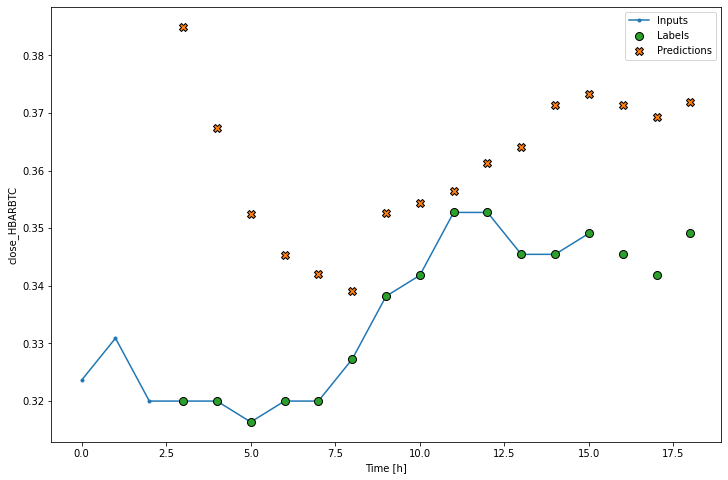

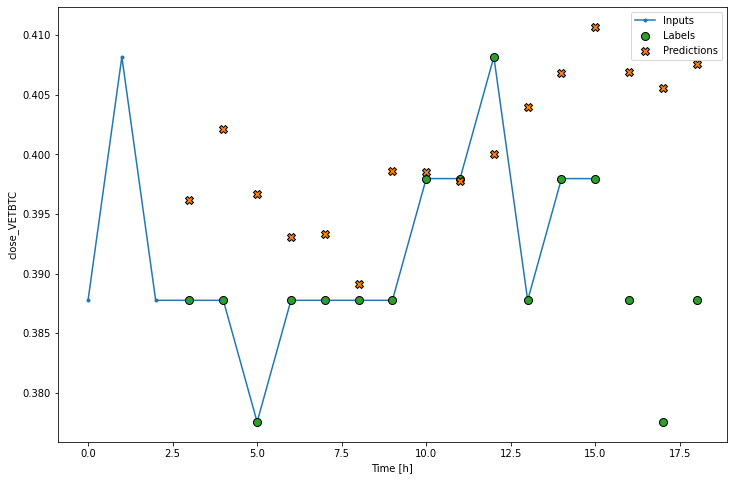

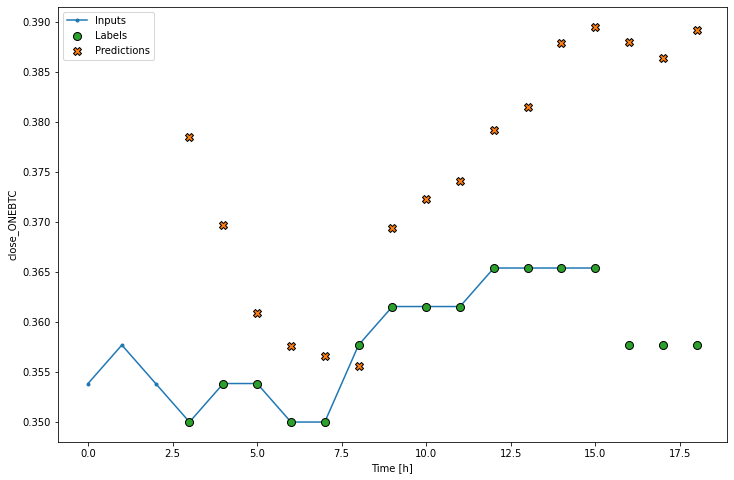

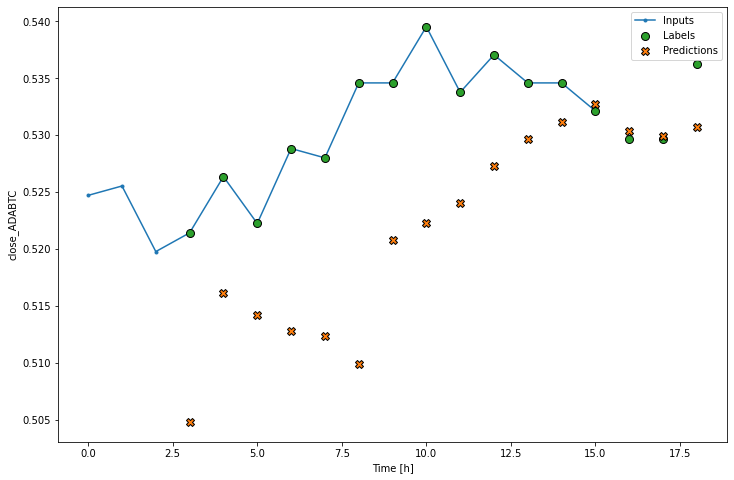

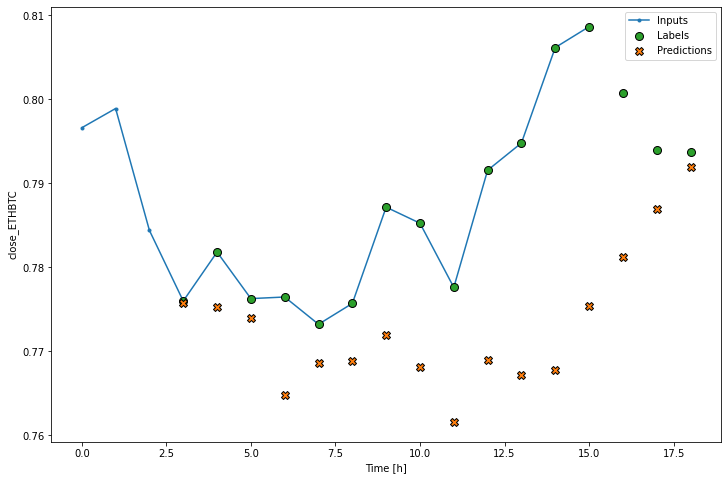

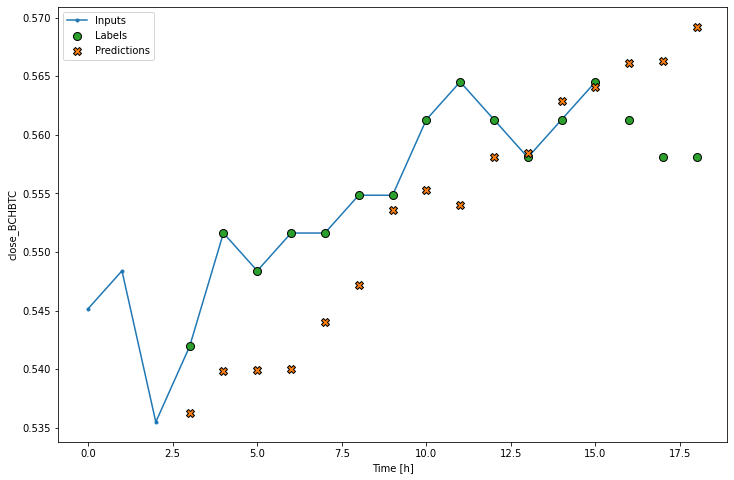

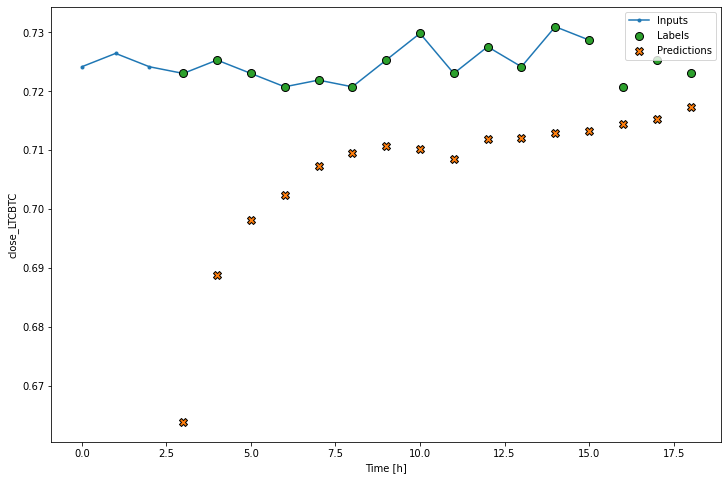

In [58]:
val_performance['model0'] = model0.evaluate(single_step_window.val)
performance['model0'] = model0.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model0, plot_col=i)

### Model 1 Adam optimizer: GRU 
> - Over fitting after the 19th epoch
> - lowest loss and val loss = loss:0.0057, val_loss:0.0052

In [59]:
model1 = Sequential()
model1.add(GRU(units=64, return_sequences=True))
model1.add(Dropout(0.7))
model1.add(Dense(units=7))
history1 = compile_and_fit(model1, single_step_window)


Epoch 1/200
192/192 [==============================] - 3s 6ms/step - loss: 0.0514 - mean_absolute_error: 0.1606 - val_loss: 0.0057 - val_mean_absolute_error: 0.0530
Epoch 2/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0165 - mean_absolute_error: 0.0989 - val_loss: 0.0043 - val_mean_absolute_error: 0.0480
Epoch 3/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0119 - mean_absolute_error: 0.0839 - val_loss: 0.0039 - val_mean_absolute_error: 0.0469
Epoch 4/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0096 - mean_absolute_error: 0.0754 - val_loss: 0.0038 - val_mean_absolute_error: 0.0484
Epoch 5/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0687 - val_loss: 0.0040 - val_mean_absolute_error: 0.0506
Epoch 6/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0644 - val_loss: 0.0044 - val_mean_absolute_error: 0.0545
Epoch 7/20

24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_absolute_error: 0.0564


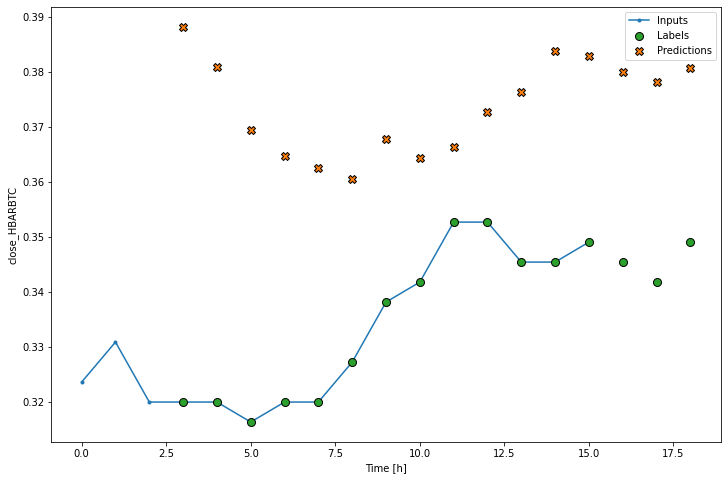

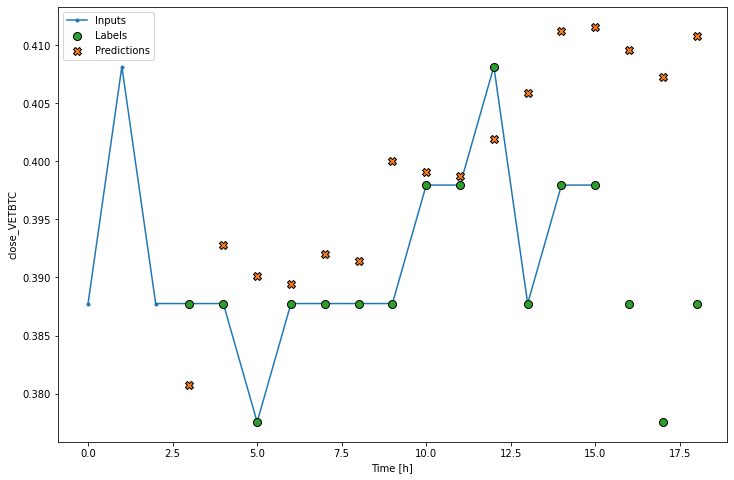

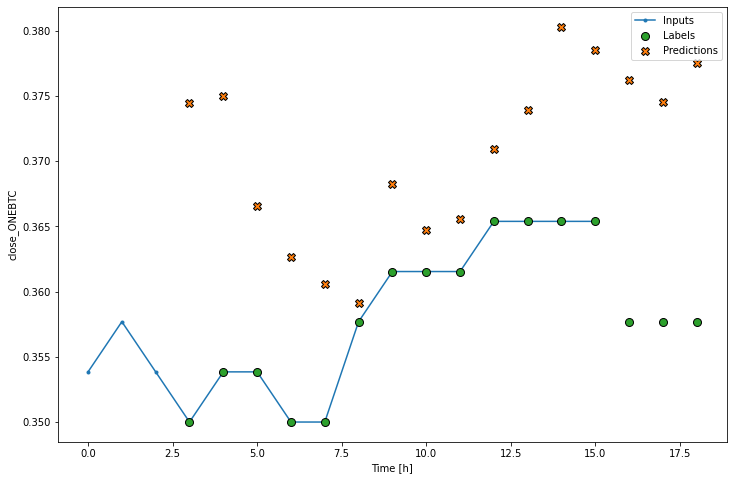

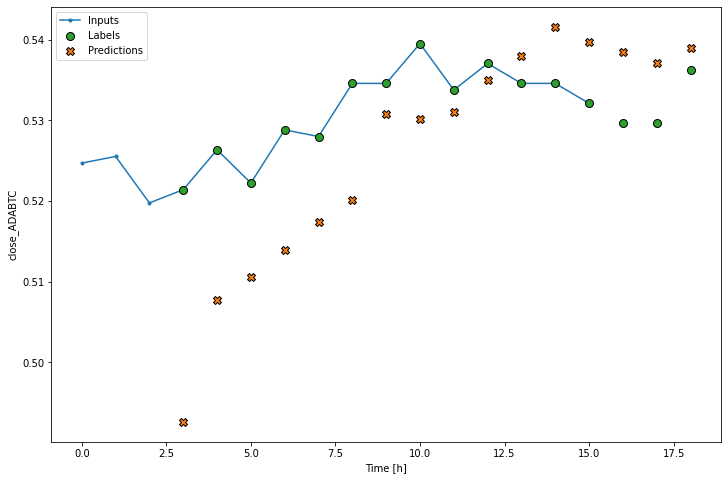

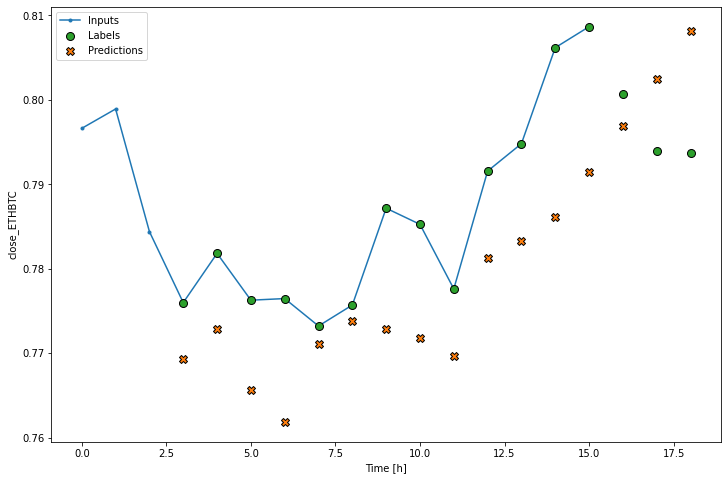

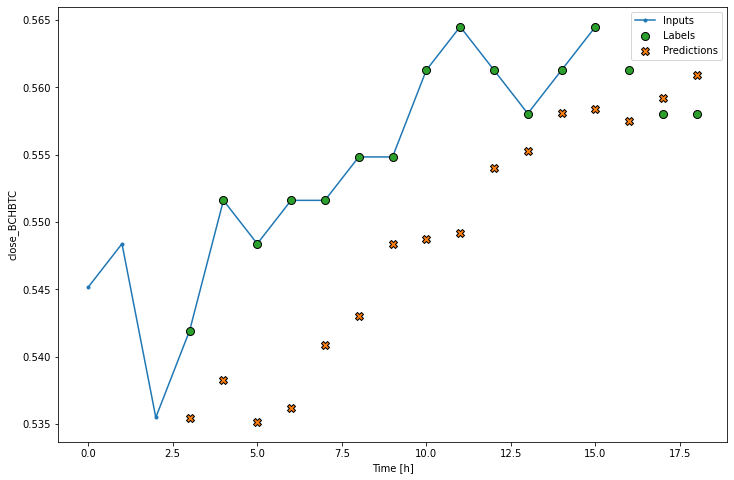

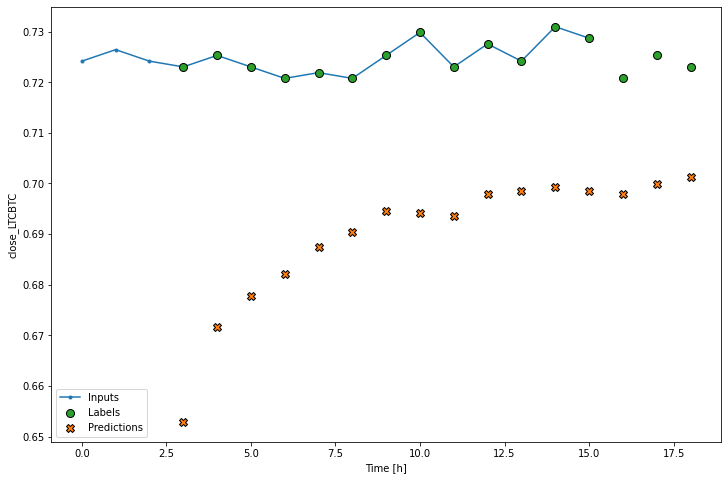

In [60]:
val_performance['model1'] = model1.evaluate(single_step_window.val)
performance['model1'] = model1.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model1, plot_col=i)

### Model 2 Adam optimizer: SimpleRNN - Best Initial Model
> - Over fitting after the 29th epoch
> - lowest loss and val loss = loss:0.0032, val_loss:0.0019

In [61]:
model2 = Sequential()
model2.add(SimpleRNN(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(Dense(units=7))
history2 = compile_and_fit(model2, single_step_window)

Epoch 1/200
192/192 [==============================] - 2s 5ms/step - loss: 0.0524 - mean_absolute_error: 0.1492 - val_loss: 0.0042 - val_mean_absolute_error: 0.0516
Epoch 2/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0115 - mean_absolute_error: 0.0826 - val_loss: 0.0032 - val_mean_absolute_error: 0.0456
Epoch 3/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0083 - mean_absolute_error: 0.0704 - val_loss: 0.0026 - val_mean_absolute_error: 0.0412
Epoch 4/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0067 - mean_absolute_error: 0.0628 - val_loss: 0.0022 - val_mean_absolute_error: 0.0379
Epoch 5/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0057 - mean_absolute_error: 0.0581 - val_loss: 0.0020 - val_mean_absolute_error: 0.0362
Epoch 6/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0049 - mean_absolute_error: 0.0541 - val_loss: 0.0020 - val_mean_absolute_error: 0.0355
Epoch 7/20

24/24 [==============================] - 0s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0253


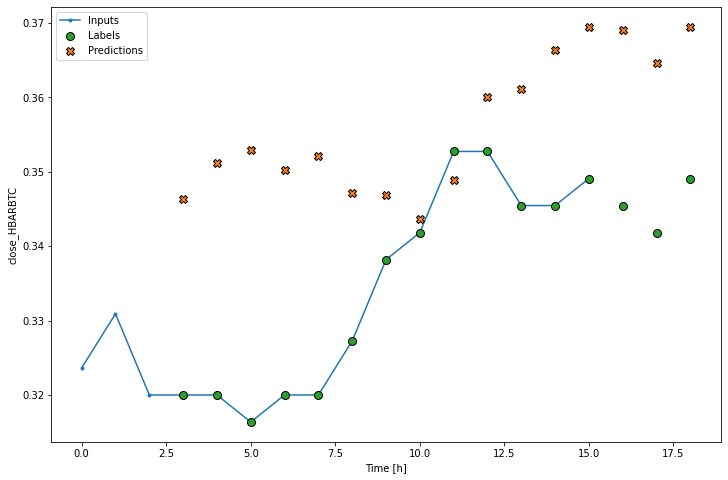

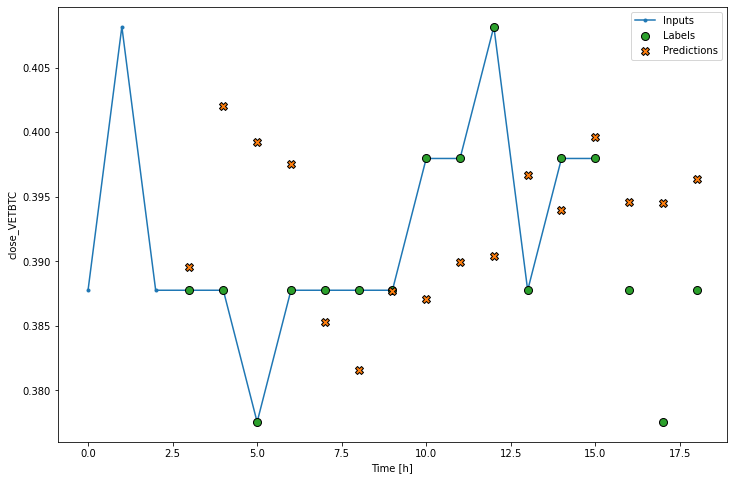

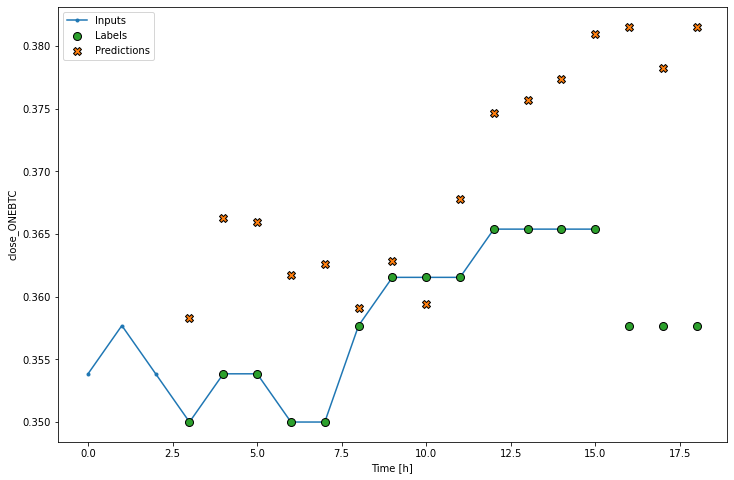

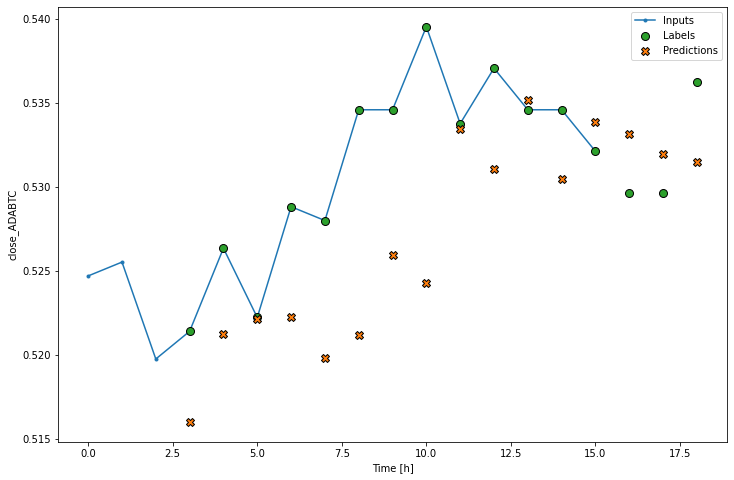

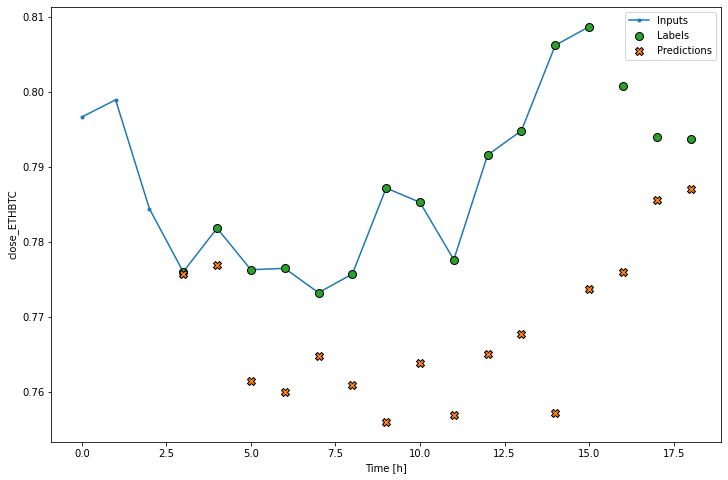

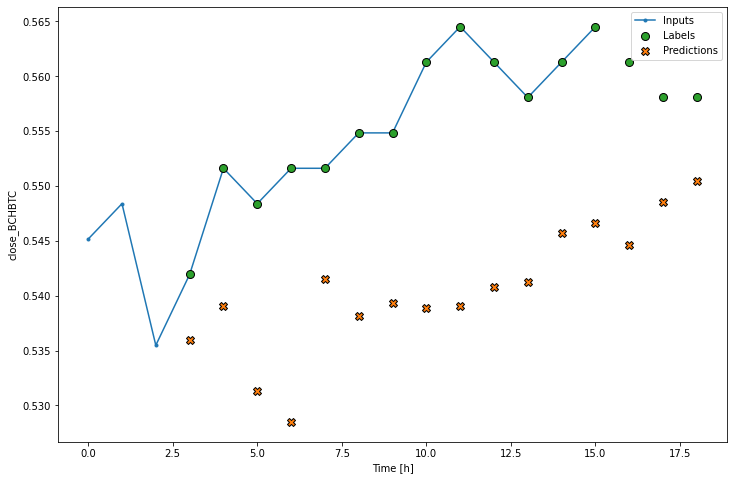

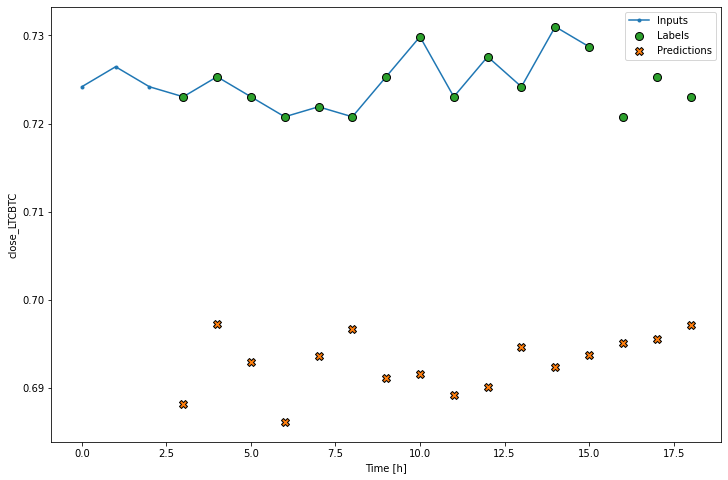

In [62]:
val_performance['model2'] = model2.evaluate(single_step_window.val)
performance['model2'] = model2.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model2, plot_col=i)

### Model 3 Adam optimizer: Bidirectional(LSTM)
> - Over fitting after the 11th epoch
> - lowest loss and val loss = loss:0.0036, val_loss:0.0037

In [63]:
model3 = Sequential()
model3.add(Bidirectional(layer=LSTM(units=64, return_sequences=True)))
model3.add(Dropout(0.6))
model3.add(Dense(units=7))
history = compile_and_fit(model3, single_step_window)

Epoch 1/200
192/192 [==============================] - 5s 9ms/step - loss: 0.0258 - mean_absolute_error: 0.1142 - val_loss: 0.0046 - val_mean_absolute_error: 0.0553
Epoch 2/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0743 - val_loss: 0.0038 - val_mean_absolute_error: 0.0476
Epoch 3/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0071 - mean_absolute_error: 0.0646 - val_loss: 0.0045 - val_mean_absolute_error: 0.0501
Epoch 4/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0057 - mean_absolute_error: 0.0581 - val_loss: 0.0048 - val_mean_absolute_error: 0.0507
Epoch 5/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0038 - val_mean_absolute_error: 0.0446
Epoch 6/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0043 - val_mean_absolute_error: 0.0482
Epoch 7/20

24/24 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_absolute_error: 0.0484


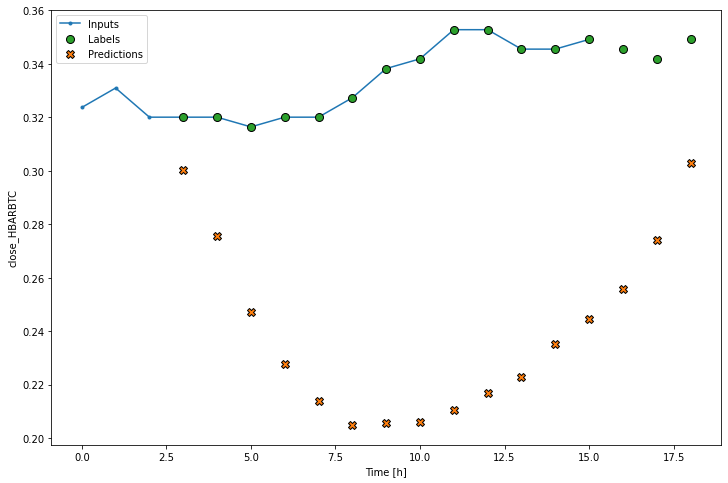

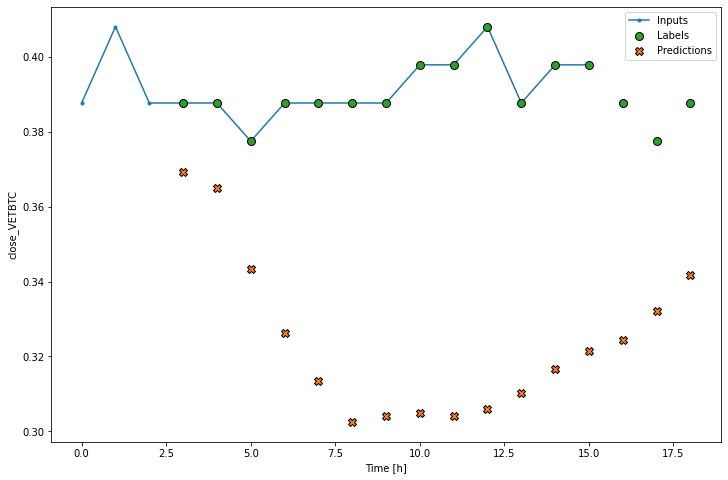

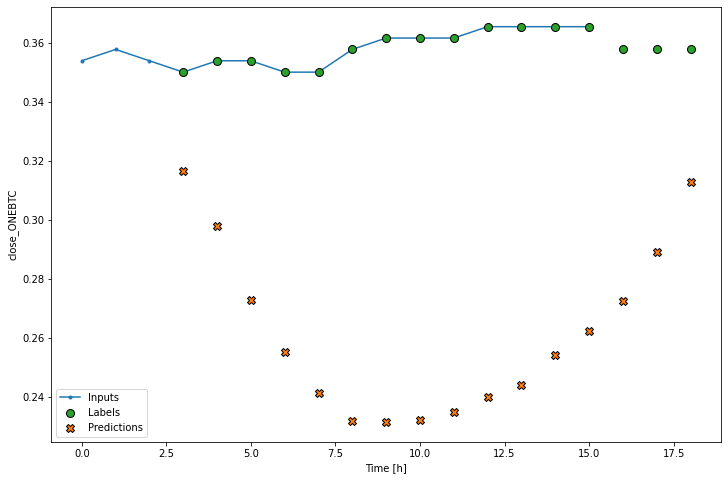

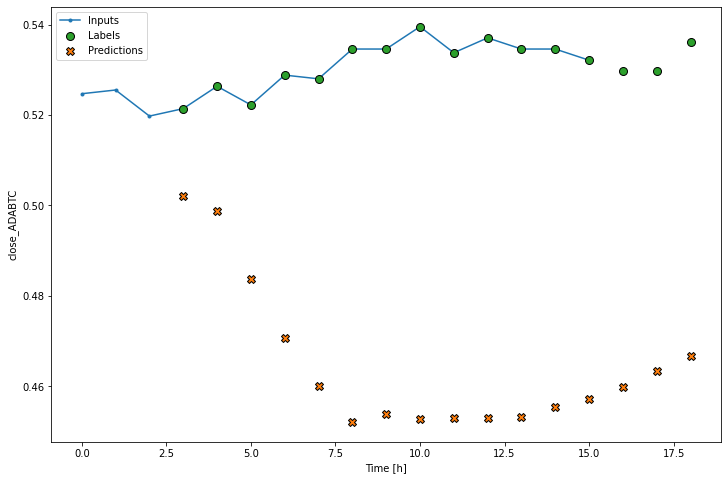

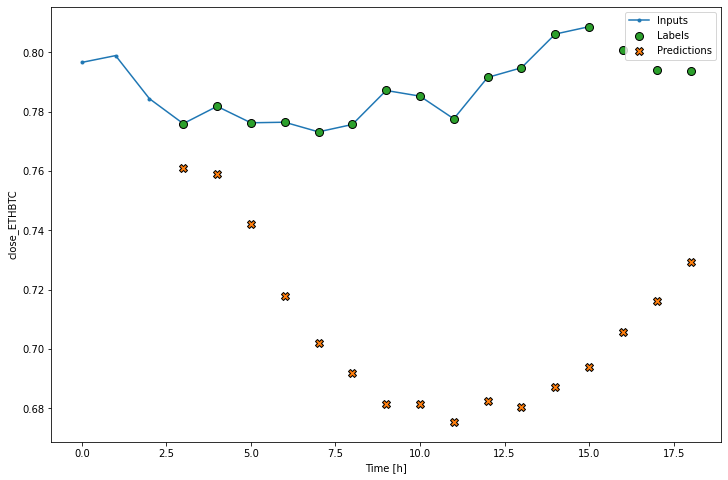

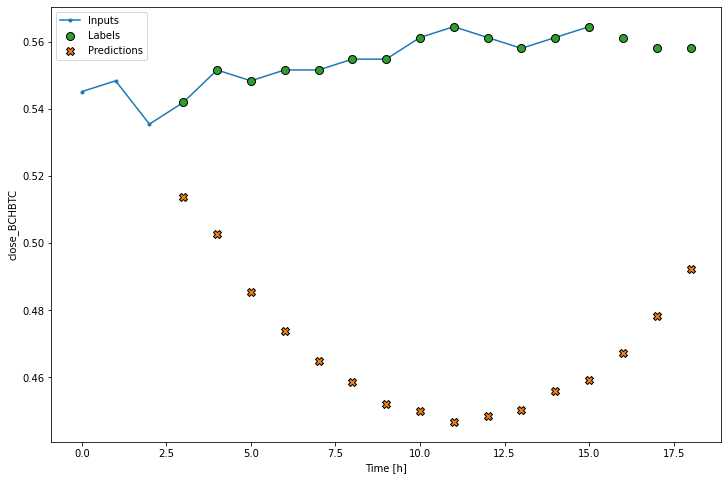

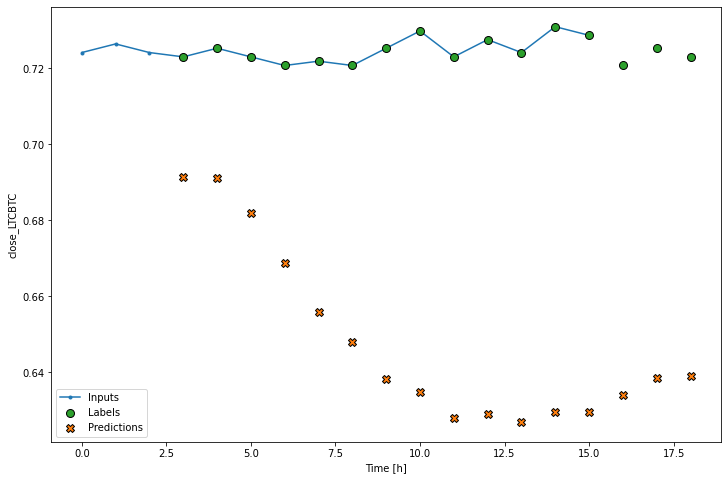

In [64]:
val_performance['model3'] = model3.evaluate(single_step_window.val)
performance['model3'] = model3.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model3, plot_col=i)

## Model Improvements

### Model 4: changing the optimizer, used SimpleRNN in a Bidirectional layer - NA
> - Over fitting after the 25th epoch
> - lowest loss and val loss = loss:0.0030, val_loss:0.0011

In [65]:
model4 = Sequential()
model4.add(Bidirectional(layer=SimpleRNN(units=64, return_sequences=True), backward_layer=SimpleRNN(units=64, return_sequences=True,go_backwards=True)))
model4.add(Dropout(0.5))
model4.add(Dense(units=7))
history = compile_and_fit(model4, single_step_window, optimizer=tf.optimizers.RMSprop())

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
# https://keras.io/api/optimizers/

Epoch 1/200
192/192 [==============================] - 3s 9ms/step - loss: 0.0636 - mean_absolute_error: 0.1811 - val_loss: 0.0018 - val_mean_absolute_error: 0.0342
Epoch 2/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0148 - mean_absolute_error: 0.0941 - val_loss: 0.0022 - val_mean_absolute_error: 0.0392
Epoch 3/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0755 - val_loss: 0.0013 - val_mean_absolute_error: 0.0266
Epoch 4/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0662 - val_loss: 0.0011 - val_mean_absolute_error: 0.0252
Epoch 5/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0064 - mean_absolute_error: 0.0615 - val_loss: 0.0010 - val_mean_absolute_error: 0.0244
Epoch 6/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0573 - val_loss: 0.0018 - val_mean_absolute_error: 0.0357
Epoch 7/20

24/24 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0263


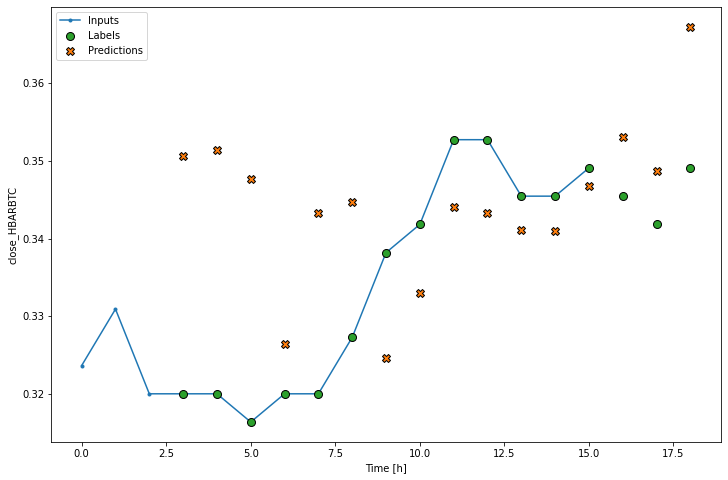

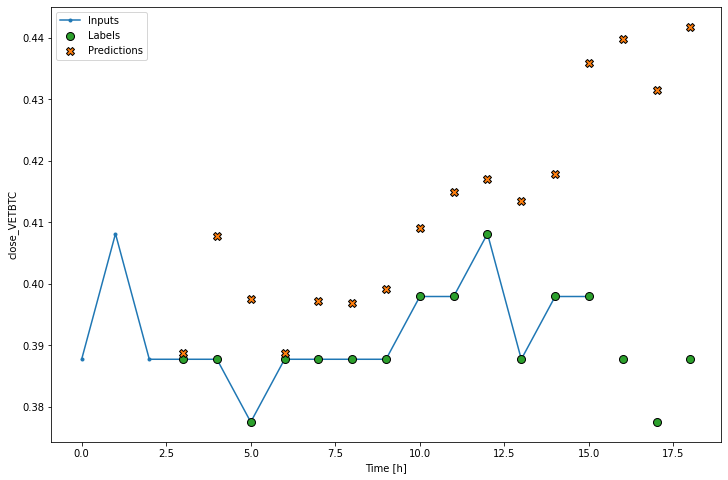

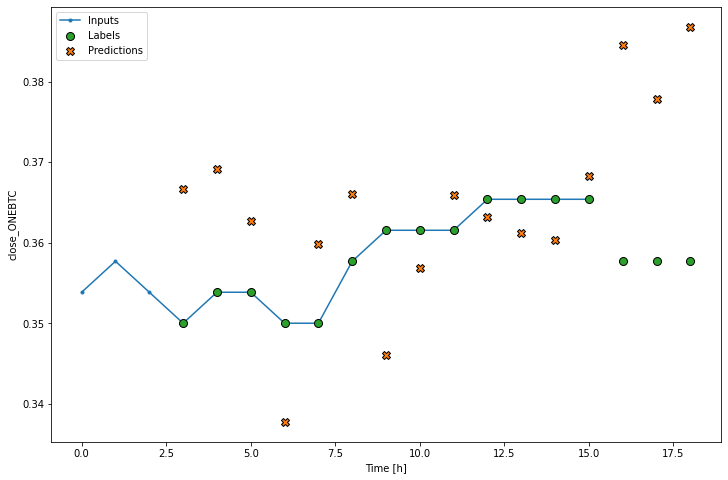

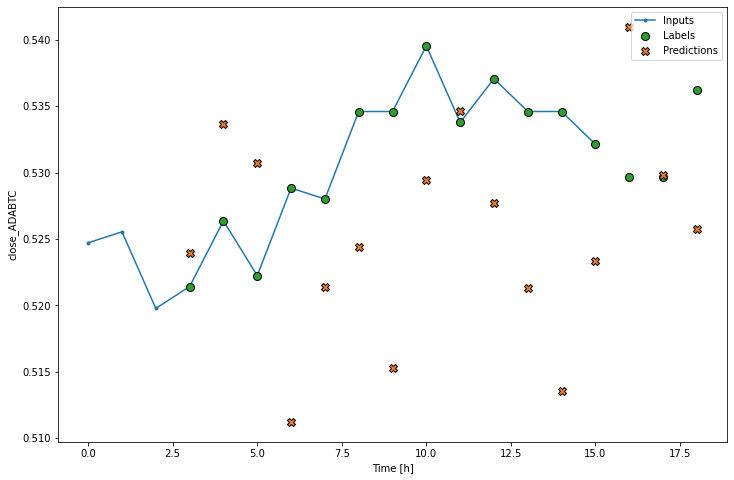

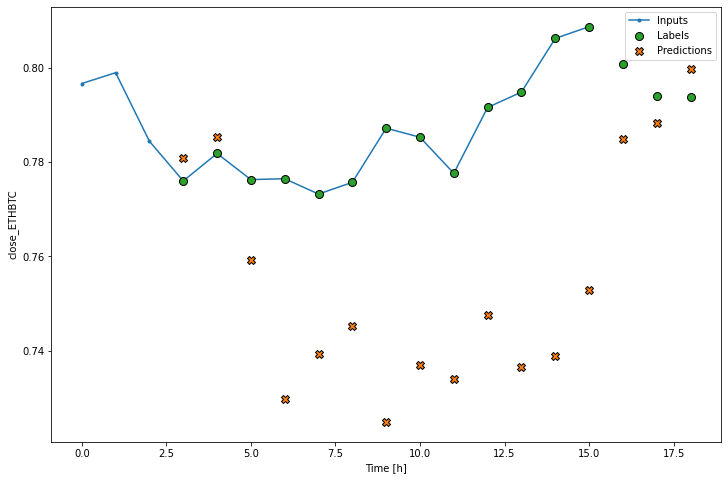

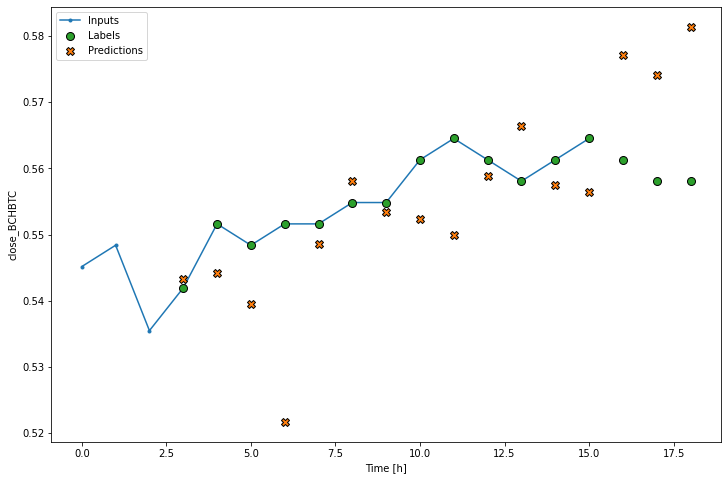

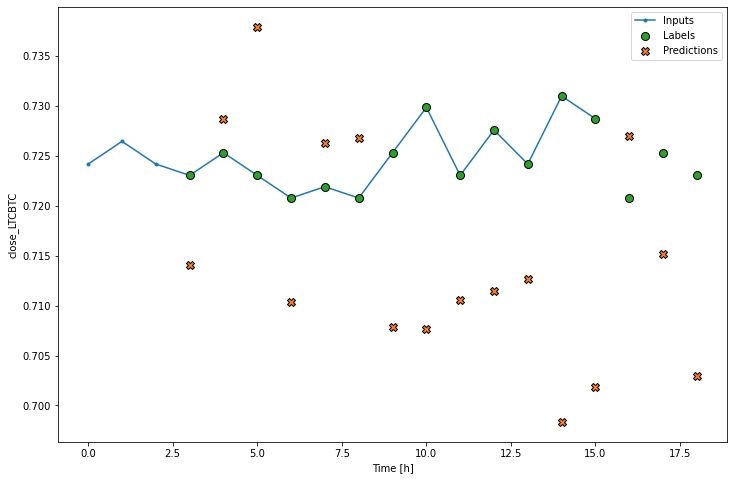

In [66]:
val_performance['model4'] = model4.evaluate(single_step_window.val)
performance['model4'] = model4.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model4, plot_col=i)

### Model 5: Bidirectional LSTM forward and SimpleRNN backwards with Adam optimizer - OKAY MODEL
> - Over fitting after the 22nd epoch
> - lowest loss and val loss = loss:0.0021, val_loss:0.0026
> - understands the direction better

In [67]:
model5 = Sequential()
model5.add(Bidirectional(layer=LSTM(units=64, return_sequences=True), backward_layer=SimpleRNN(units=64, return_sequences=True,go_backwards=True)))
model5.add(Dropout(0.5))
model5.add(Dense(units=7))
history = compile_and_fit(model5, single_step_window)

Epoch 1/200
192/192 [==============================] - 4s 9ms/step - loss: 0.0397 - mean_absolute_error: 0.1282 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359
Epoch 2/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0086 - mean_absolute_error: 0.0716 - val_loss: 0.0013 - val_mean_absolute_error: 0.0280
Epoch 3/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0065 - mean_absolute_error: 0.0622 - val_loss: 9.9441e-04 - val_mean_absolute_error: 0.0248
Epoch 4/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 7.8745e-04 - val_mean_absolute_error: 0.0216
Epoch 5/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 6.7425e-04 - val_mean_absolute_error: 0.0192
Epoch 6/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 7.3768e-04 - val_mean_absolute_error: 0

24/24 [==============================] - 0s 3ms/step - loss: 6.9662e-04 - mean_absolute_error: 0.0185


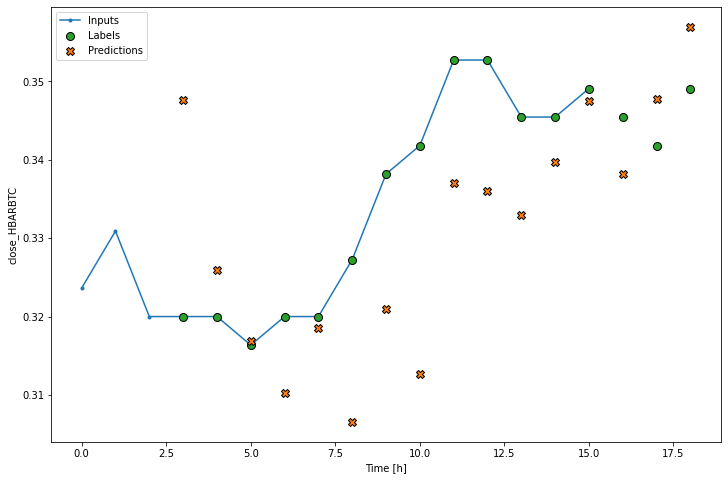

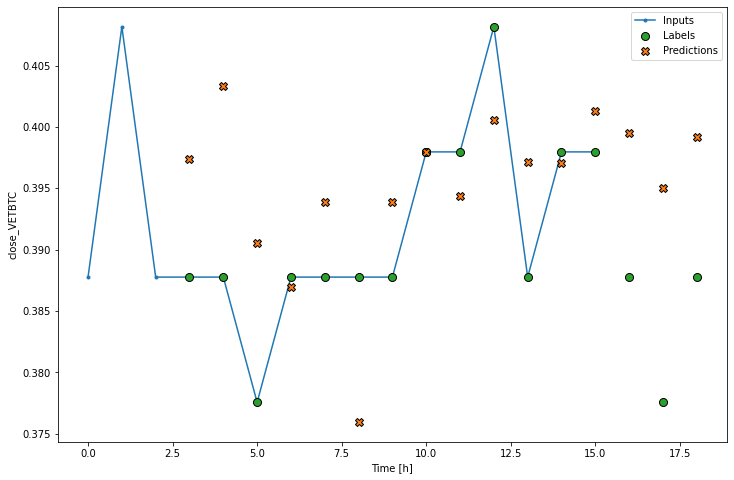

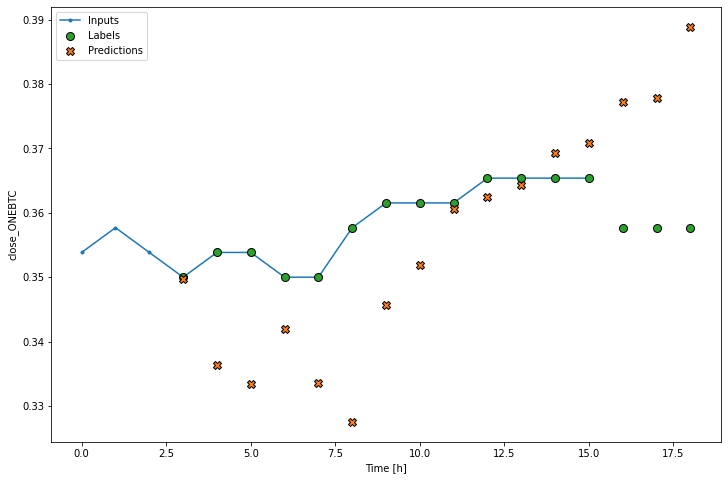

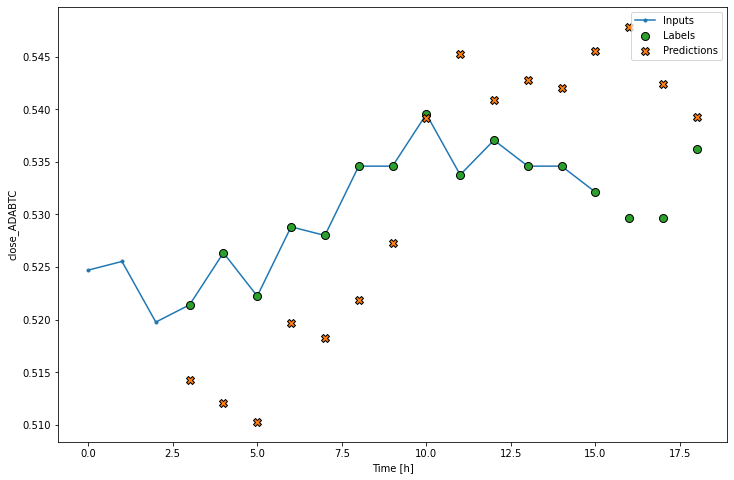

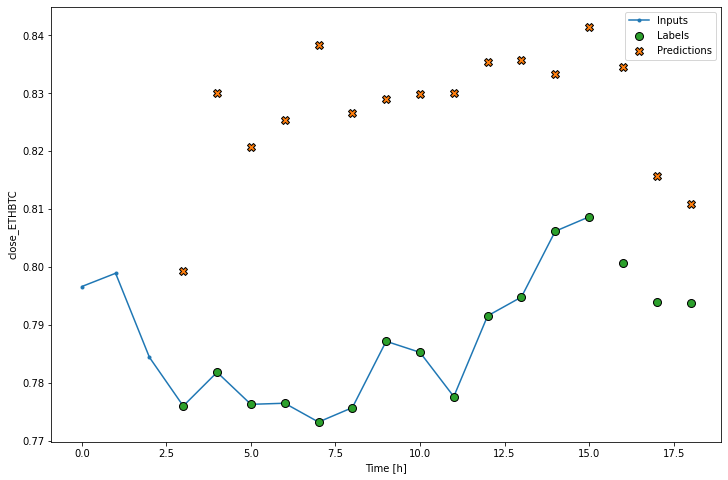

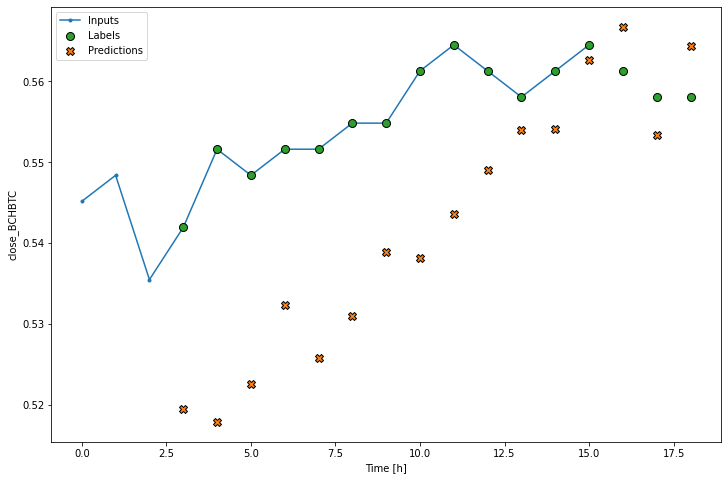

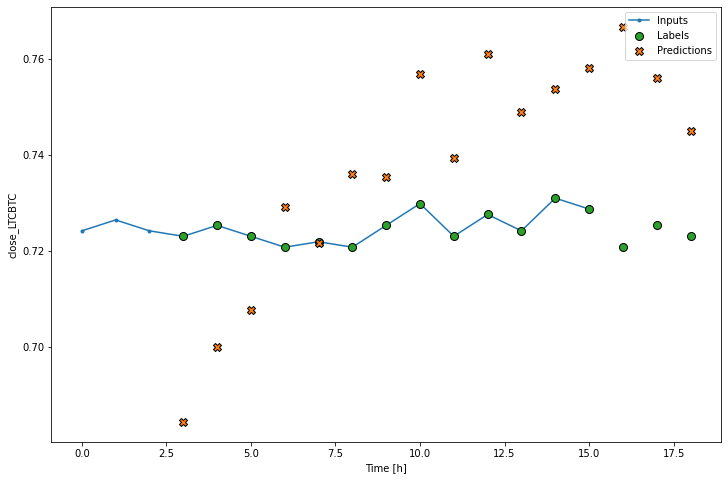

In [68]:
val_performance['model5'] = model5.evaluate(single_step_window.val)
performance['model5'] = model5.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model5, plot_col=i)

### Model 6: Bidirectional foward LSTM backwards SimpleRNN RMSprop - Best Model
> - Over fitting after the -- epoch
> - lowest loss and val loss = loss:--, val_loss:--


In [69]:
model6 = Sequential()
model6.add(Bidirectional(layer=LSTM(units=64, return_sequences=True), backward_layer=SimpleRNN(units=64, return_sequences=True, go_backwards=True)))
model6.add(Dropout(0.4))
model6.add(Dense(units=7))
history = compile_and_fit(model6, single_step_window, optimizer=tf.optimizers.RMSprop(), patience=15)

Epoch 1/200
192/192 [==============================] - 4s 8ms/step - loss: 0.0361 - mean_absolute_error: 0.1344 - val_loss: 0.0022 - val_mean_absolute_error: 0.0342
Epoch 2/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0098 - mean_absolute_error: 0.0768 - val_loss: 0.0013 - val_mean_absolute_error: 0.0296
Epoch 3/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0641 - val_loss: 0.0013 - val_mean_absolute_error: 0.0276
Epoch 4/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0572 - val_loss: 8.4077e-04 - val_mean_absolute_error: 0.0216
Epoch 5/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 9.3106e-04 - val_mean_absolute_error: 0.0222
Epoch 6/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0010 - val_mean_absolute_error: 0.0232
Ep

24/24 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0324


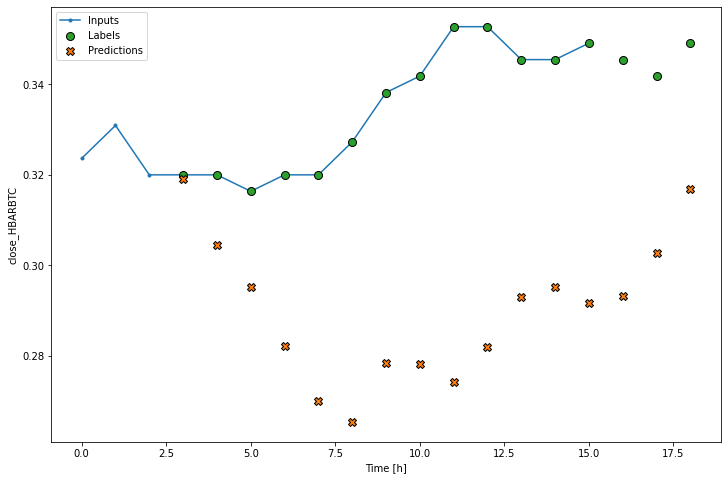

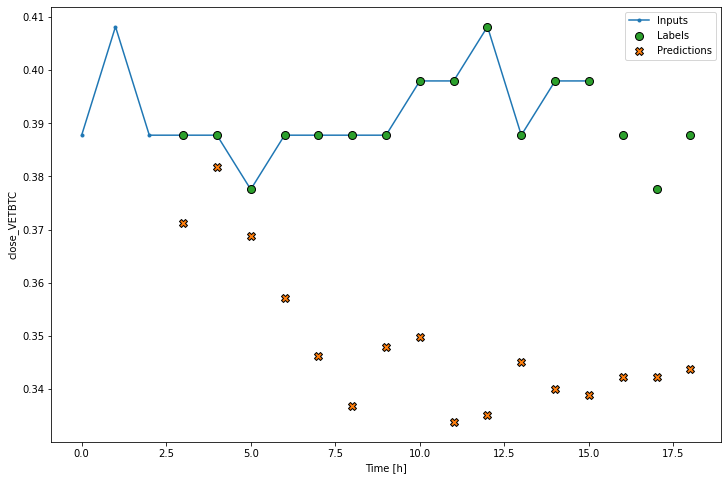

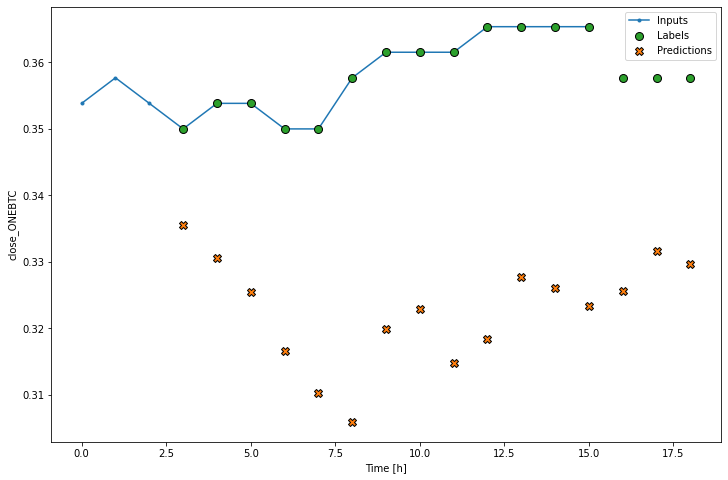

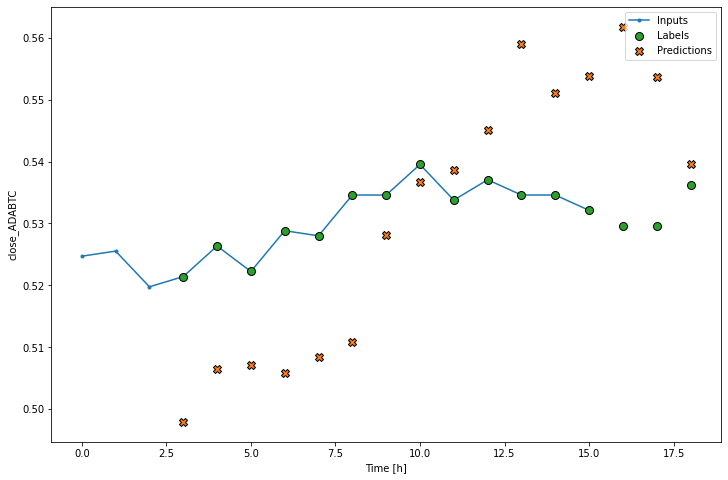

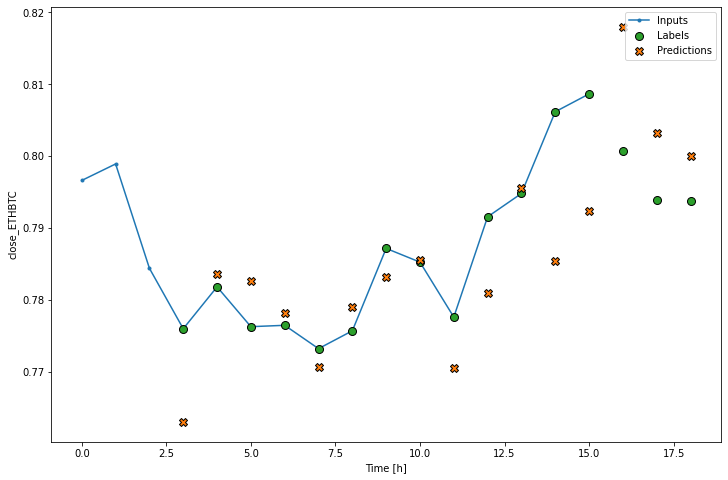

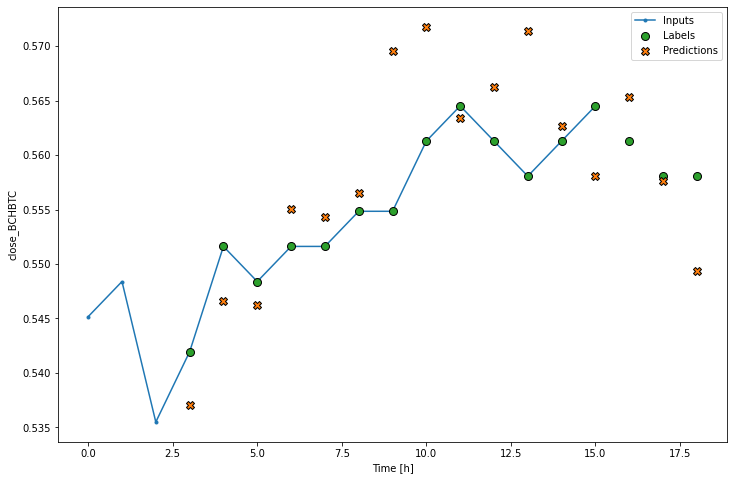

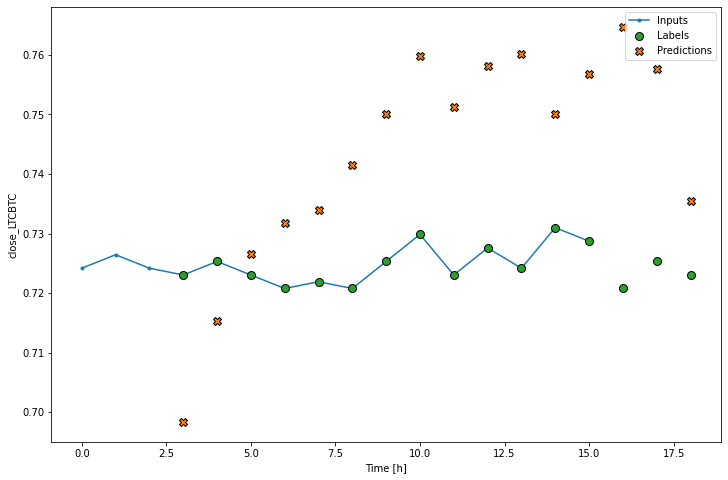

In [70]:
val_performance['model6'] = model6.evaluate(single_step_window.val)
performance['model6'] = model6.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model6, plot_col=i)

### Model 7: Bidirectional foward LSTM backwards LSTM RMSprop optimizer - NA
> - Over fitting after the -- epoch
> - lowest loss and val loss = loss:, val_loss:

In [71]:
model7 = Sequential()
model7.add(Bidirectional(layer=LSTM(units=64, return_sequences=True), backward_layer=LSTM(units=64, return_sequences=True, go_backwards=True)))
model7.add(Dropout(0.5))
model7.add(Dense(units=7))
history = compile_and_fit(model7, single_step_window, patience=10)

Epoch 1/200
192/192 [==============================] - 5s 8ms/step - loss: 0.0237 - mean_absolute_error: 0.1092 - val_loss: 0.0035 - val_mean_absolute_error: 0.0432
Epoch 2/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0081 - mean_absolute_error: 0.0694 - val_loss: 0.0030 - val_mean_absolute_error: 0.0408
Epoch 3/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410
Epoch 4/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0548 - val_loss: 0.0030 - val_mean_absolute_error: 0.0433
Epoch 5/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0043 - mean_absolute_error: 0.0505 - val_loss: 0.0026 - val_mean_absolute_error: 0.0396
Epoch 6/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0038 - mean_absolute_error: 0.0475 - val_loss: 0.0025 - val_mean_absolute_error: 0.0388
Epoch 7/20

24/24 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0345


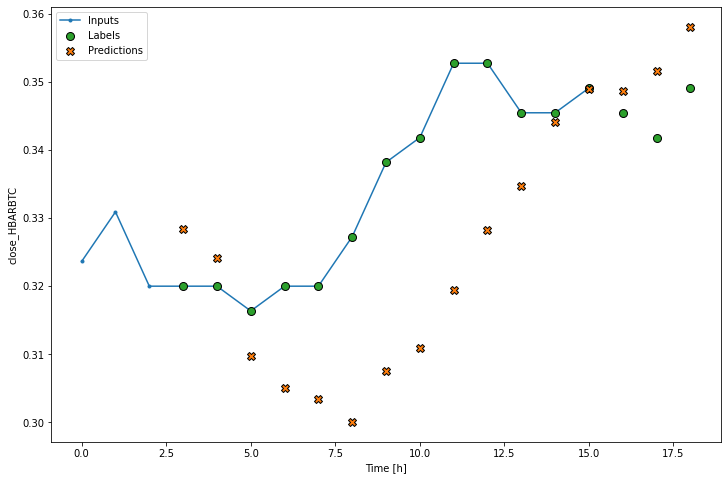

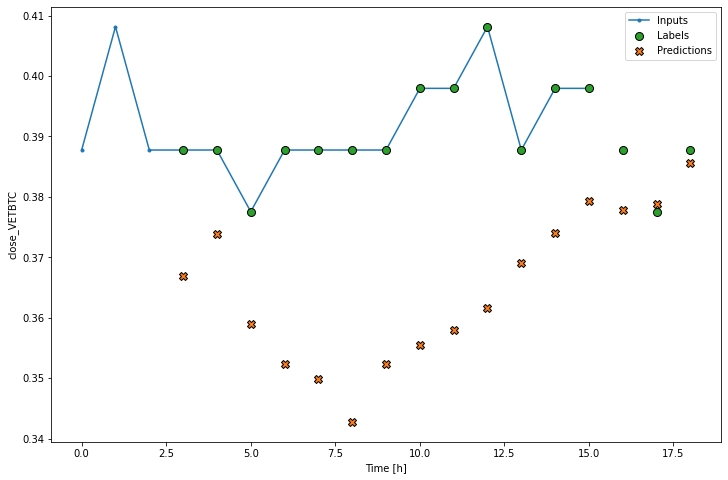

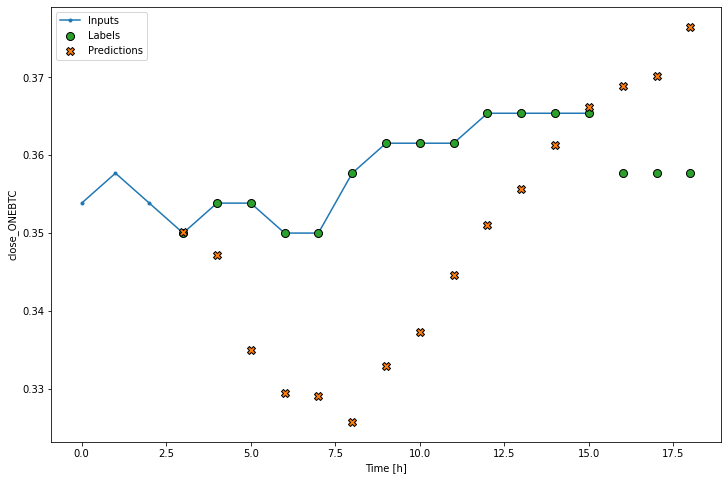

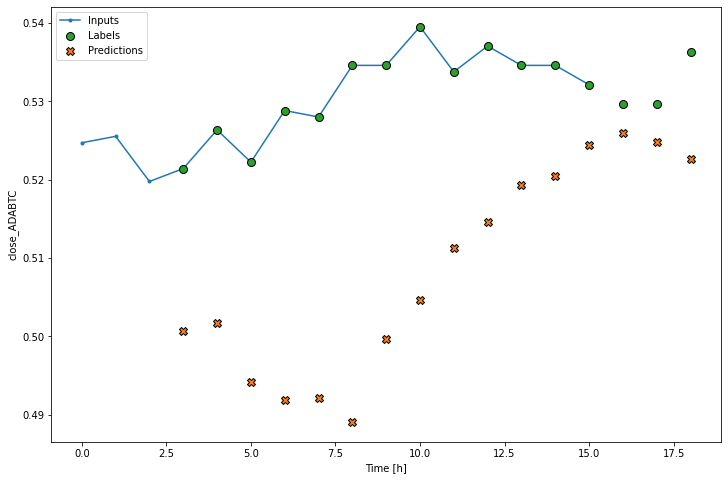

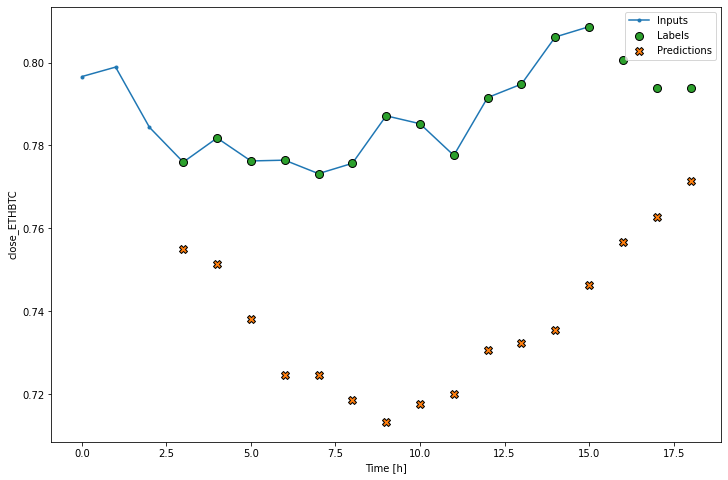

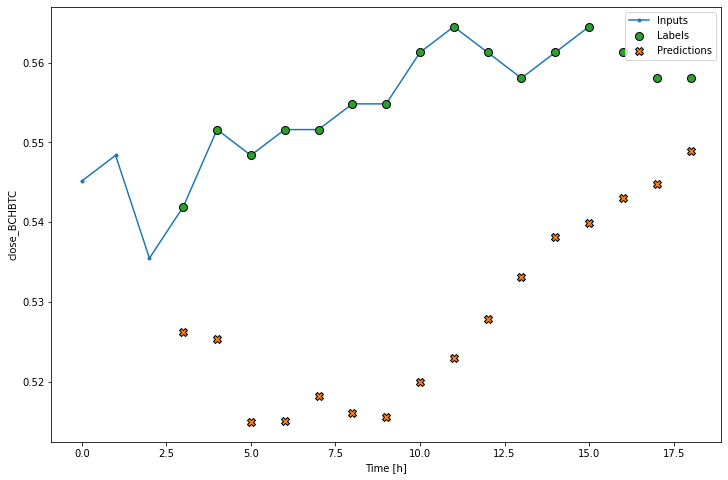

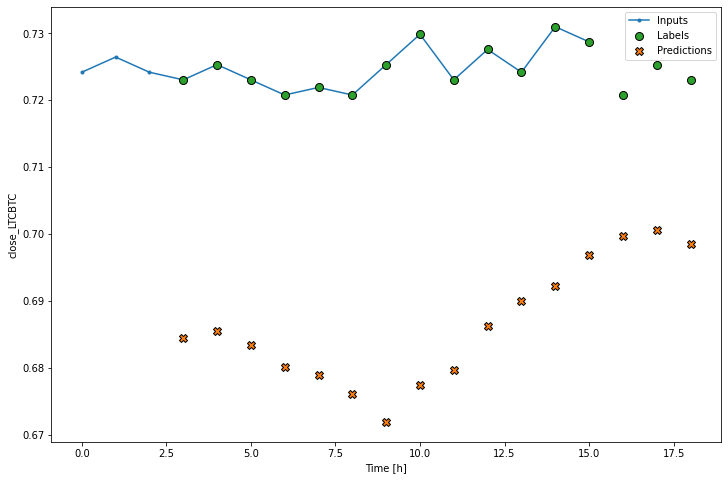

In [72]:
val_performance['model7'] = model7.evaluate(single_step_window.val)
performance['model7'] = model7.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model7, plot_col=i)

### Model 8: Bidirectional foward LSTM backwards LSTM Adam optimizer - NA
> - Over fitting after the 22nd epoch
> - lowest loss and val loss = loss:0.0021, val_loss:0.0026
> - understands the direction better

In [73]:
model8 = Sequential()
model8.add(LSTM(units=64, return_sequences=True))
model8.add(Dropout(0.4))
model8.add(Bidirectional(layer=LSTM(units=49, return_sequences=True), backward_layer=SimpleRNN(units=49, return_sequences=True,go_backwards=True)))
# model8.add(SimpleRNN(units=49, return_sequences=True))
model8.add(Dropout(0.8))
model8.add(Dense(units=7))
history = compile_and_fit(model8, single_step_window, patience=15)

Epoch 1/200
192/192 [==============================] - 6s 11ms/step - loss: 0.0470 - mean_absolute_error: 0.1537 - val_loss: 0.0065 - val_mean_absolute_error: 0.0658
Epoch 2/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0157 - mean_absolute_error: 0.0978 - val_loss: 0.0077 - val_mean_absolute_error: 0.0694
Epoch 3/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0121 - mean_absolute_error: 0.0858 - val_loss: 0.0124 - val_mean_absolute_error: 0.0877
Epoch 4/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0100 - mean_absolute_error: 0.0777 - val_loss: 0.0142 - val_mean_absolute_error: 0.0951
Epoch 5/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0089 - mean_absolute_error: 0.0732 - val_loss: 0.0146 - val_mean_absolute_error: 0.0967
Epoch 6/200
192/192 [==============================] - 1s 7ms/step - loss: 0.0083 - mean_absolute_error: 0.0705 - val_loss: 0.0137 - val_mean_absolute_error: 0.0940
Epoch 7/2

24/24 [==============================] - 0s 3ms/step - loss: 0.0122 - mean_absolute_error: 0.0890


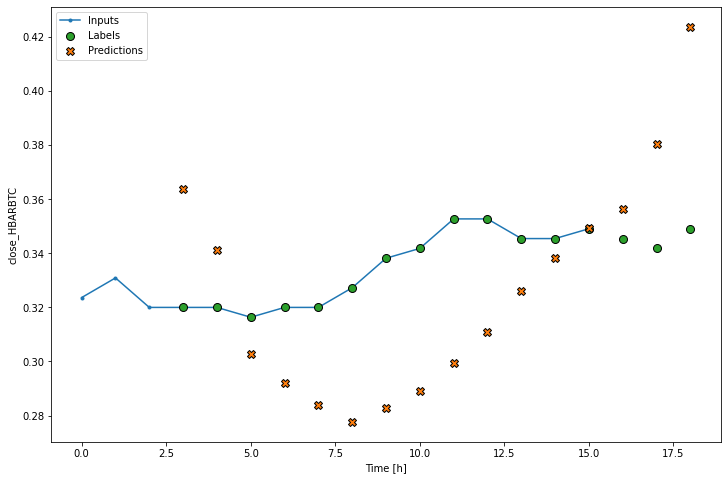

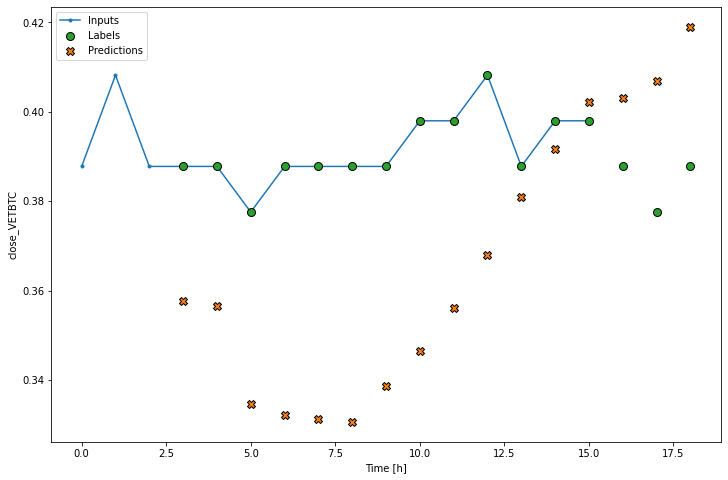

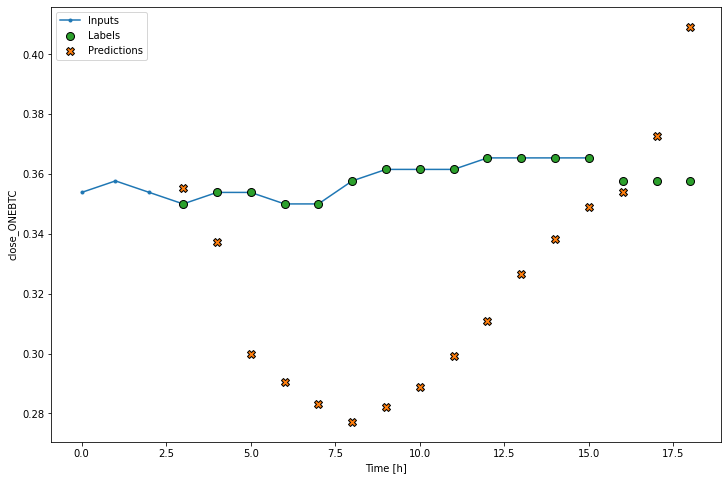

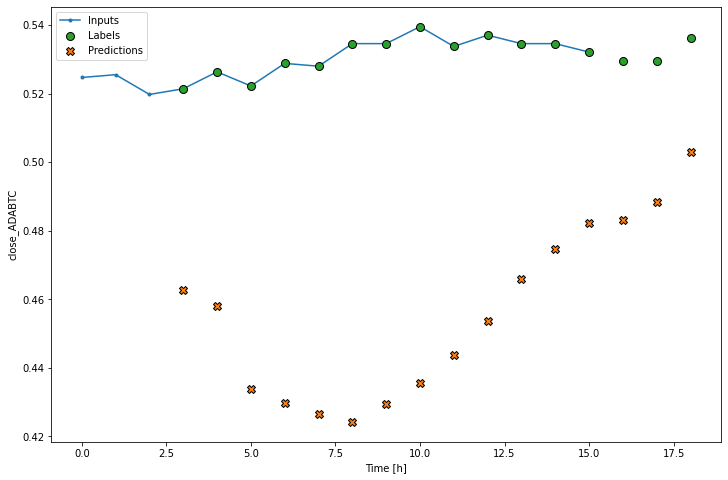

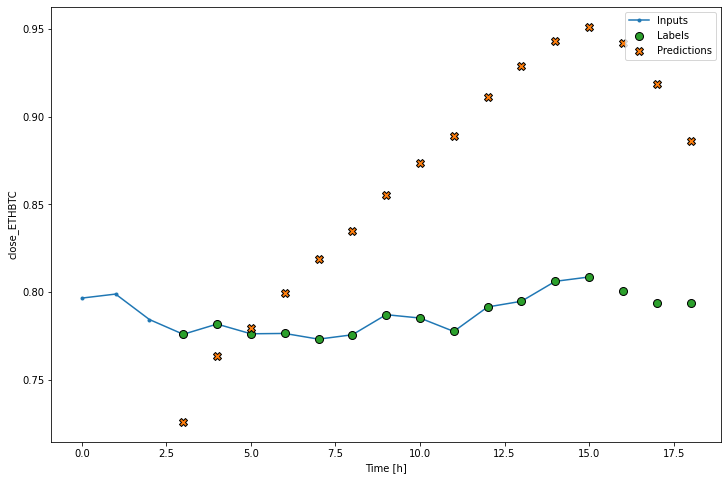

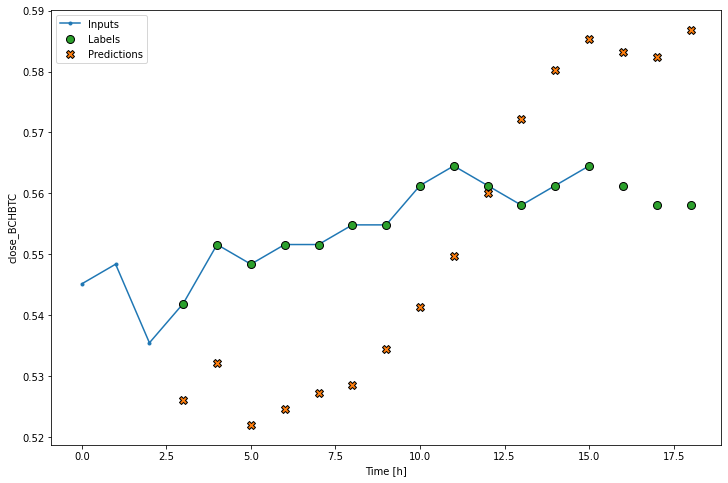

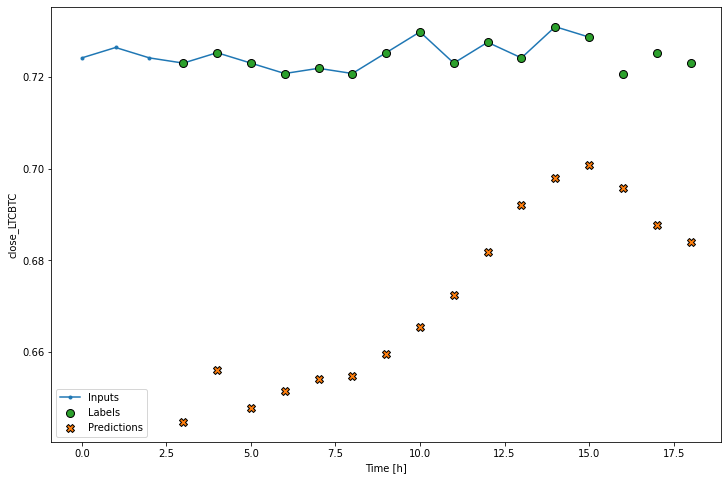

In [74]:
val_performance['model8'] = model8.evaluate(single_step_window.val)
performance['model8'] = model8.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model8, plot_col=i)

### Model 9: NA
> - Over fitting after the 22nd epoch
> - lowest loss and val loss = loss:0.0021, val_loss:0.0026
> - understands the direction better

In [75]:
model9 = Sequential()
model9.add(Bidirectional(layer=LSTM(units=64, return_sequences=True), backward_layer=SimpleRNN(units=64, return_sequences=True, go_backwards=True)))
model9.add(Dropout(0.4))
model9.add(Dense(units=7))
history = compile_and_fit(model9, single_step_window, optimizer=tf.optimizers.RMSprop(), patience=4)

Epoch 1/200
192/192 [==============================] - 4s 8ms/step - loss: 0.0363 - mean_absolute_error: 0.1357 - val_loss: 0.0024 - val_mean_absolute_error: 0.0372
Epoch 2/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0097 - mean_absolute_error: 0.0764 - val_loss: 0.0012 - val_mean_absolute_error: 0.0270
Epoch 3/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0640 - val_loss: 0.0010 - val_mean_absolute_error: 0.0250
Epoch 4/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0565 - val_loss: 0.0010 - val_mean_absolute_error: 0.0251
Epoch 5/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 9.6801e-04 - val_mean_absolute_error: 0.0237
Epoch 6/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 9.3132e-04 - val_mean_absolute_error: 0.0249
Ep

24/24 [==============================] - 0s 3ms/step - loss: 7.3388e-04 - mean_absolute_error: 0.0192


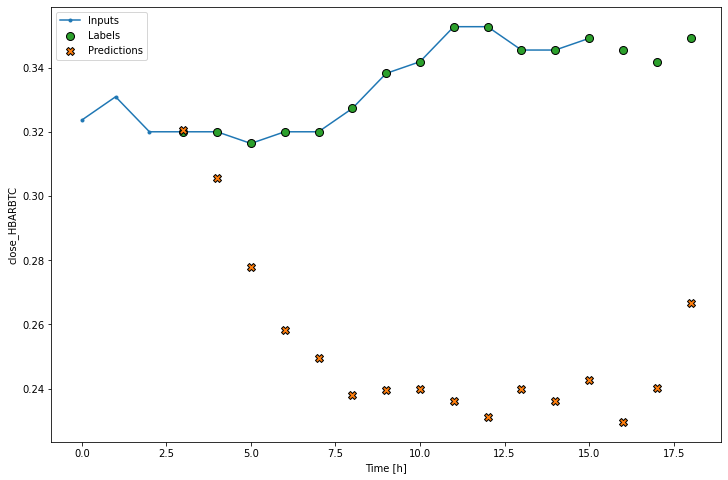

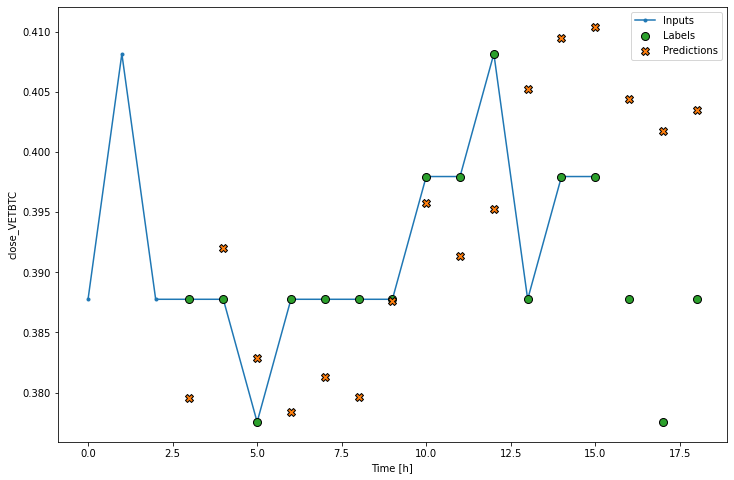

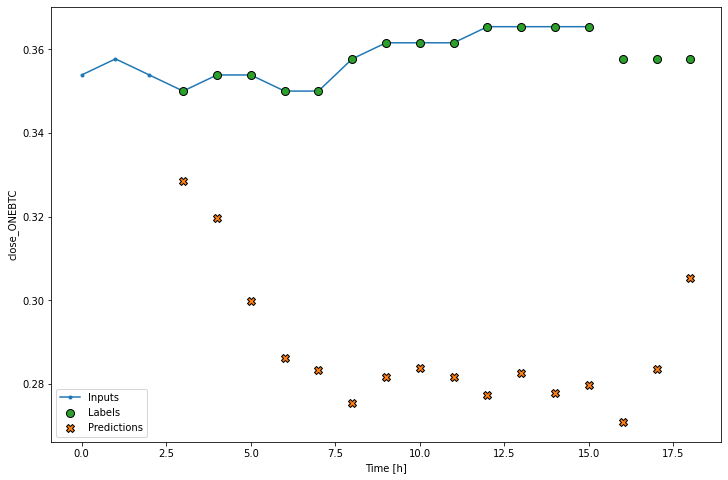

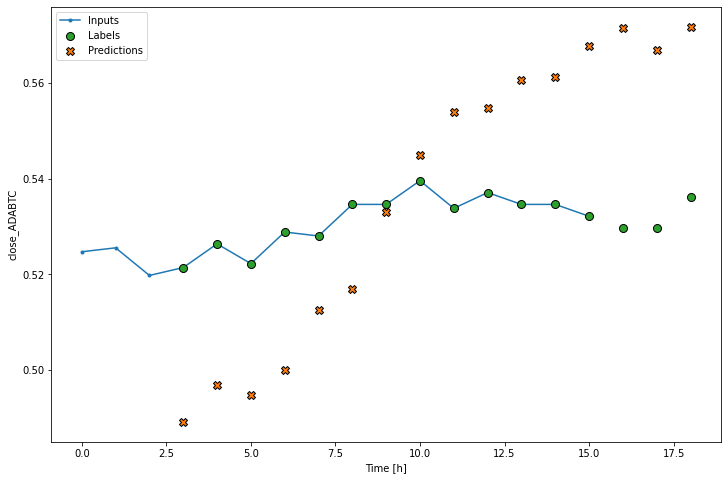

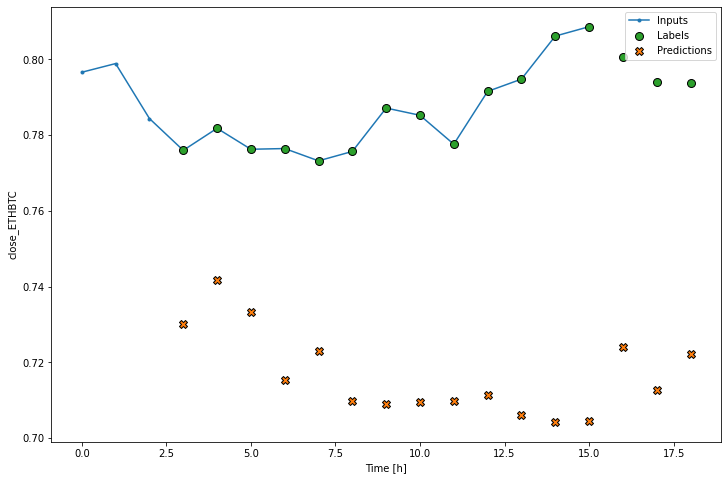

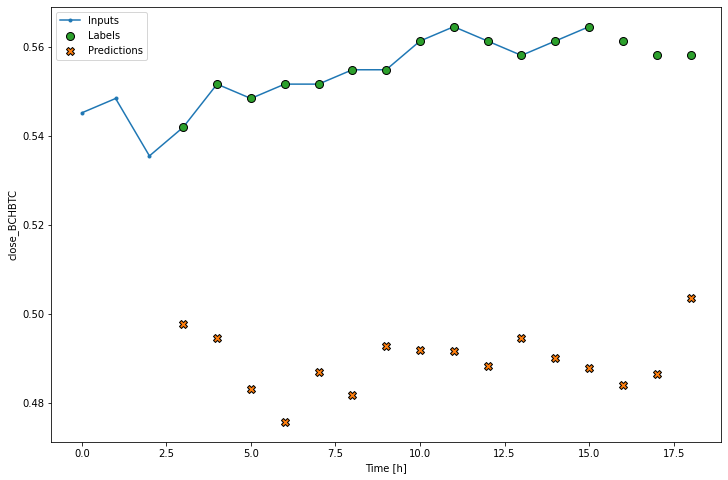

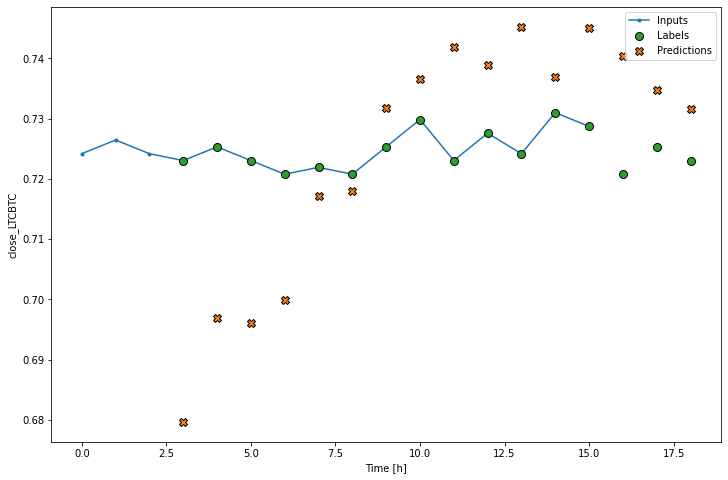

In [76]:
val_performance['model9'] = model9.evaluate(single_step_window.val)
performance['model9'] = model9.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model9, plot_col=i)

# DF 15 Strat4 15 min model

## Reformating Model

In [77]:
def get_column_format(df):
  datetime = df['datetime'].iloc[0]
  temp = df[['ticker_id', 'open', 'high', 'low', 'close', 'volume',
             'sma_5', 'ema_18', 'ema_20', 'sma_50', 'sma_89', 'ema_144', 'ema_35',
             'ku', 'a', 'b', 'c', 'rv', 'y', 'x', 'sl', 'ss']]
  
  ans = []
  for i, r in temp.iterrows():
    ticker = r['ticker_id']
    temp = {'datetime': datetime, 'ticker_id': ticker}
    for curr_col in ['ticker_id', 'open', 'high', 'low', 'close', 'volume',
                     'sma_5', 'ema_18', 'ema_20', 'sma_50', 'sma_89', 'ema_144', 'ema_35',
                     'ku', 'a', 'b', 'c', 'rv', 'y', 'x', 'sl', 'ss']:
      temp[f"{curr_col}_{ticker}"] = [r[curr_col]]
    del temp['ticker_id']
    ans.append(temp)
  ans = {k: v for d in ans for k, v in d.items()}
  return pd.DataFrame(ans)

def make_X_y_df(df_time):
  master_df = pd.DataFrame()
  datetime_unq = df_time['datetime'].unique()
  for datetime in datetime_unq:
    df = df_time[df_time['datetime'] == datetime] 
    master_df = pd.concat([master_df, get_column_format(df)], axis=0)
  return master_df
      
def get_columns_that_startwith(df, col_str):
  return df[df.columns[pd.Series(df.columns).str.contains(col_str)]]


## Feature Engineering

In [78]:
df_15_strat4 = make_X_y_df(df_15_strat4)
df_15_strat4.set_index('datetime', inplace = True)

In [79]:
df_15_strat4.drop(columns=list(get_columns_that_startwith(df_15_strat4, 'KNCBTC').columns), inplace=True)
df_15_strat4.drop(columns=list(get_columns_that_startwith(df_15_strat4, 'USDT').columns), inplace=True)
df_15_strat4.drop(columns=list(get_columns_that_startwith(df_15_strat4, 'ticker_id').columns), inplace=True)

In [80]:
df_15_strat4.isna().sum()

open_HBARBTC       96
high_HBARBTC       96
low_HBARBTC        96
close_HBARBTC      96
volume_HBARBTC     96
                 ... 
rv_LTCBTC         384
y_LTCBTC          384
x_LTCBTC          384
sl_LTCBTC         384
ss_LTCBTC         384
Length: 147, dtype: int64

In [81]:
df_15_strat4.dropna(axis=0, inplace=True)
df_15_strat4.sort_index(inplace=True)

In [82]:
column_indices = {name: i for i, name in enumerate(df_15_strat4.columns)}
column_indices = [column_indices.get(k) for k in ['close_ADABTC', 'close_ONEBTC', 'close_HBARBTC', 'close_VETBTC', 'close_LTCBTC', 'close_BCHBTC', 'close_ETHBTC']]
column_indices

[66, 45, 3, 24, 129, 108, 87]

In [83]:
train_index = round(df_15_strat4.shape[0] * .8)
validation_index = round(df_15_strat4.shape[0] * .1)
test_index = round(df_15_strat4.shape[0] * .1)
train_index, validation_index, test_index

(6132, 766, 766)

In [84]:
train_df = df_15_strat4.iloc[:train_index]
val_df = df_15_strat4.iloc[train_index:(train_index+validation_index)]
test_df = df_15_strat4[(train_index+validation_index):(train_index+validation_index+test_index)]
train_df.shape, val_df.shape, test_df.shape

((6132, 147), (766, 147), (766, 147))

In [85]:
y = get_columns_that_startwith(df_15_strat4, 'close')
y

close_HBARBTC  close_VETBTC  close_ONEBTC  \
datetime                                                               
2022-03-19 17:00:00+00:00       0.000005  1.220000e-06      0.000003   
2022-03-19 17:15:00+00:00       0.000005  1.200000e-06      0.000003   
2022-03-19 17:30:00+00:00       0.000005  1.210000e-06      0.000003   
2022-03-19 17:45:00+00:00       0.000005  1.200000e-06      0.000003   
2022-03-19 18:00:00+00:00       0.000005  1.220000e-06      0.000003   
...                                  ...           ...           ...   
2022-06-07 12:00:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 12:15:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 12:30:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 12:45:00+00:00       0.000003  1.010000e-06      0.000001   
2022-06-07 13:00:00+00:00       0.000003  9.900000e-07      0.000001   

                           close_ADABTC  close_ETHBTC  close_BCHBTC  \
datetime                                                              
2022-03-19 17:00:00+00:00      0.000021      0.069983       0.00773   
2022-03-19 17:15:00+00:00      0.000021      0.069963       0.00770   
2022-03-19 17:30:00+00:00      0.000021      0.069999       0.00768   
2022-03-19 17:45:00+00:00      0.000021      0.069927       0.00769   
2022-03-19 18:00:00+00:00      0.000021      0.069786       0.00770   
...                                 ...           ...           ...   
2022-06-07 12:00:00+00:00      0.000021      0.059892       0.00594   
2022-06-07 12:15:00+00:00      0.000020      0.059698       0.00591   
2022-06-07 12:30:00+00:00      0.000020      0.059638       0.00589   
2022-06-07 12:45:00+00:00      0.000020      0.059876       0.00587   
2022-06-07 13:00:00+00:00      0.000020      0.059446       0.00583   

                           close_LTCBTC  
datetime                                 
2022-03-19 17:00:00+00:00      0.002777  
2022-03-19 17:15:00+00:00      0.002792  
2022-03-19 17:30:00+00:00      0.002775  
2022-03-19 17:45:00+00:00      0.002789  
2022-03-19 18:00:00+00:00      0.002782  
...                                 ...  
2022-06-07 12:00:00+00:00      0.002090  
2022-06-07 12:15:00+00:00      0.002083  
2022-06-07 12:30:00+00:00      0.002085  
2022-06-07 12:45:00+00:00      0.002073  
2022-06-07 13:00:00+00:00      0.002072  

[7665 rows x 7 columns]

## Scale

In [86]:
sc = MinMaxScaler(feature_range=(0,1))
train_df_scal = pd.DataFrame(sc.fit_transform(train_df), columns=train_df.columns)
val_df_scal = pd.DataFrame(sc.transform(val_df), columns=val_df.columns)

## Window Gen

In [87]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_scal, val_df=val_df_scal, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [88]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [89]:
def plot(self, model=None, plot_col='', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  plt.subplot(1, 1, 1)
  plt.ylabel(f'{plot_col}')
  plt.plot(self.input_indices, inputs[1, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)
  if self.label_columns:
    label_col_index = self.label_columns_indices.get(plot_col, None)
  else:
    label_col_index = plot_col_index

  plt.scatter(self.label_indices, labels[1, :, label_col_index],
              edgecolors='k', label='Labels', c='#2ca02c', s=64)
  if model is not None:
    predictions = model(inputs)
    plt.scatter(self.label_indices, predictions[1, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)
  plt.legend()
  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [90]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [91]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [92]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [93]:
baseline = Baseline(label_index=tf.cast(column_indices, tf.int32))

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
# val_performance['baseline'] = baseline.evaluate(single_step_window.val)
# performance['baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


In [94]:
list(y.columns)

['close_HBARBTC',
 'close_VETBTC',
 'close_ONEBTC',
 'close_ADABTC',
 'close_ETHBTC',
 'close_BCHBTC',
 'close_LTCBTC']

In [95]:
wide_window = WindowGenerator(
    input_width=16, label_width=16, shift=3,
    label_columns=list(y.columns))

wide_window

Total window size: 19
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Label column name(s): ['close_HBARBTC', 'close_VETBTC', 'close_ONEBTC', 'close_ADABTC', 'close_ETHBTC', 'close_BCHBTC', 'close_LTCBTC']

In [96]:
single_step_window = WindowGenerator(
    input_width=3, label_width=3, shift=3,
    label_columns=list(y.columns))
single_step_window

Total window size: 6
Input indices: [0 1 2]
Label indices: [3 4 5]
Label column name(s): ['close_HBARBTC', 'close_VETBTC', 'close_ONEBTC', 'close_ADABTC', 'close_ETHBTC', 'close_BCHBTC', 'close_LTCBTC']

## Basic Model Testing

In [97]:
def compile_and_fit(model, window, patience=7, MAX_EPOCHS = 200, optimizer=tf.keras.optimizers.Adam()):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# tf.keras.optimizers.Adam()
# tf.optimizers.RMSprop()


### Model 0: - NA

In [98]:
model0 = Sequential()
model0.add(LSTM(units=64, return_sequences=True))
model0.add(Dropout(0.6))
model0.add(Dense(units=7))
history = compile_and_fit(model0, single_step_window)

Epoch 1/200
192/192 [==============================] - 3s 6ms/step - loss: 0.0593 - mean_absolute_error: 0.1797 - val_loss: 0.0127 - val_mean_absolute_error: 0.0666
Epoch 2/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0215 - mean_absolute_error: 0.1132 - val_loss: 0.0092 - val_mean_absolute_error: 0.0591
Epoch 3/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0156 - mean_absolute_error: 0.0959 - val_loss: 0.0072 - val_mean_absolute_error: 0.0517
Epoch 4/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0850 - val_loss: 0.0069 - val_mean_absolute_error: 0.0520
Epoch 5/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0103 - mean_absolute_error: 0.0777 - val_loss: 0.0064 - val_mean_absolute_error: 0.0500
Epoch 6/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0087 - mean_absolute_error: 0.0712 - val_loss: 0.0069 - val_mean_absolute_error: 0.0529
Epoch 7/20

24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0547


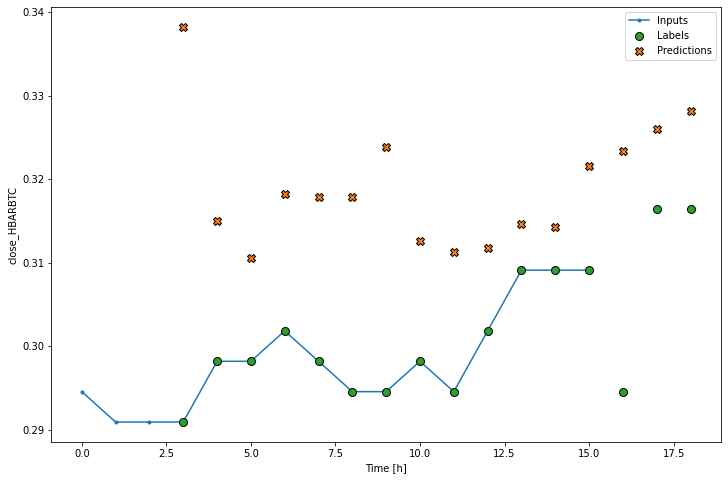

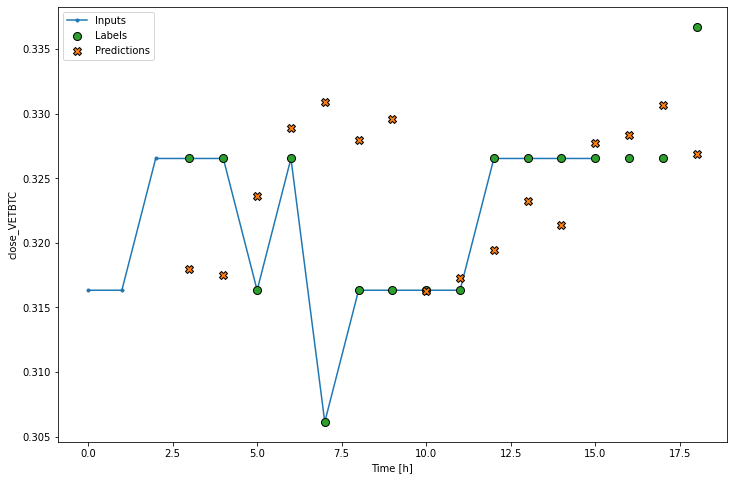

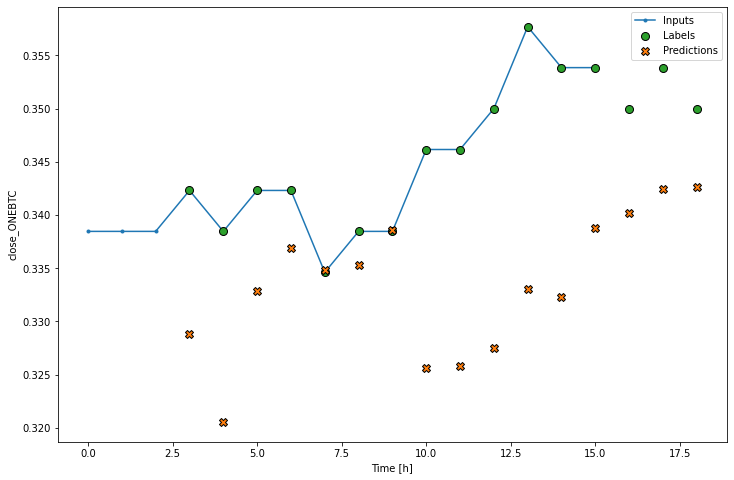

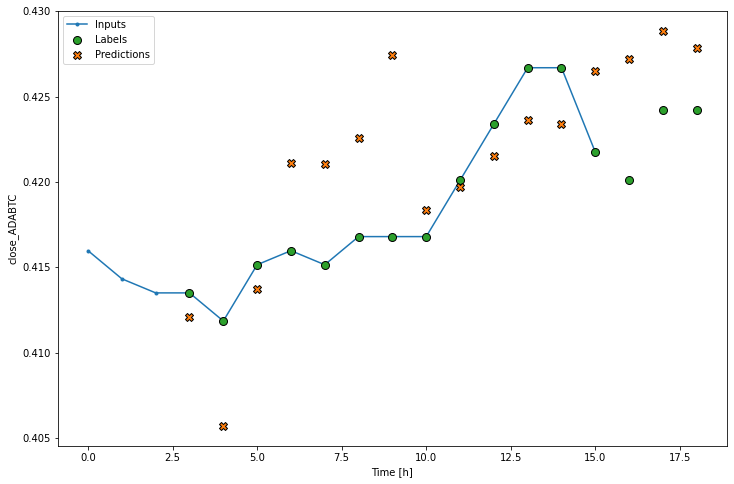

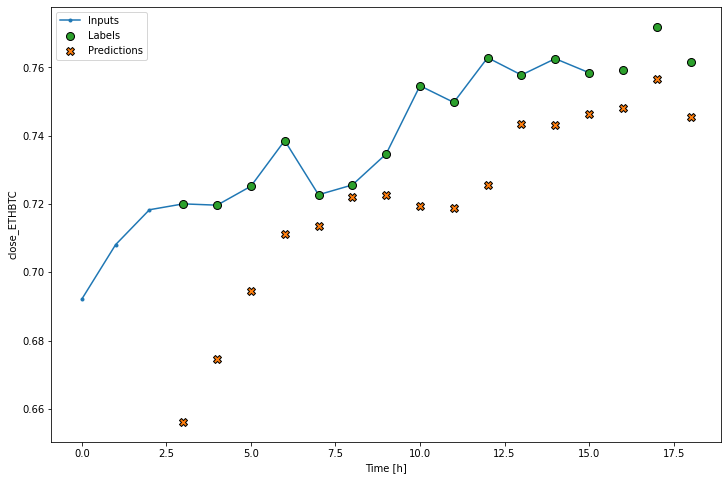

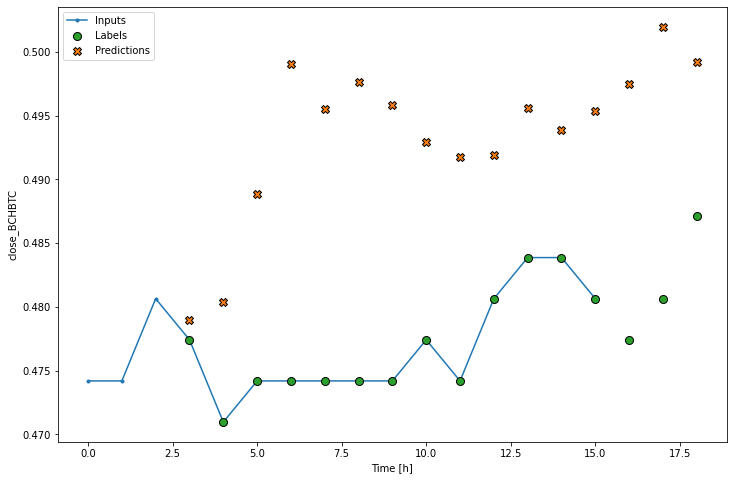

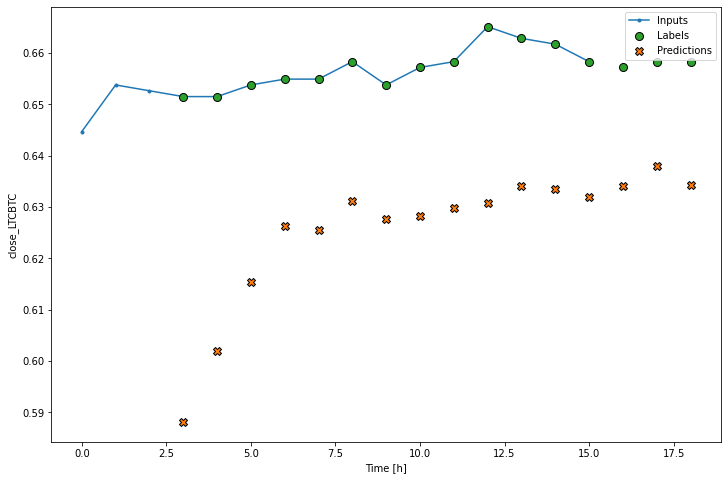

In [99]:
val_performance['model0'] = model0.evaluate(single_step_window.val)
performance['model0'] = model0.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model0, plot_col=i)

### Model 1: - NA

In [100]:
model1 = Sequential()
model1.add(GRU(units=64, return_sequences=True))
model1.add(Dropout(0.7))
model1.add(Dense(units=7))
history1 = compile_and_fit(model1, single_step_window)


Epoch 1/200
192/192 [==============================] - 3s 5ms/step - loss: 0.0435 - mean_absolute_error: 0.1498 - val_loss: 0.0073 - val_mean_absolute_error: 0.0659
Epoch 2/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0930 - val_loss: 0.0046 - val_mean_absolute_error: 0.0498
Epoch 3/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0106 - mean_absolute_error: 0.0791 - val_loss: 0.0042 - val_mean_absolute_error: 0.0479
Epoch 4/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0706 - val_loss: 0.0044 - val_mean_absolute_error: 0.0504
Epoch 5/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0073 - mean_absolute_error: 0.0658 - val_loss: 0.0043 - val_mean_absolute_error: 0.0521
Epoch 6/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0625 - val_loss: 0.0050 - val_mean_absolute_error: 0.0583
Epoch 7/20

24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0466


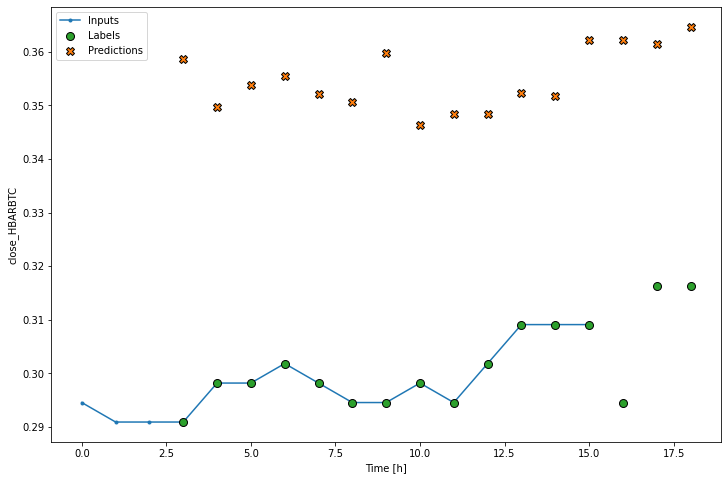

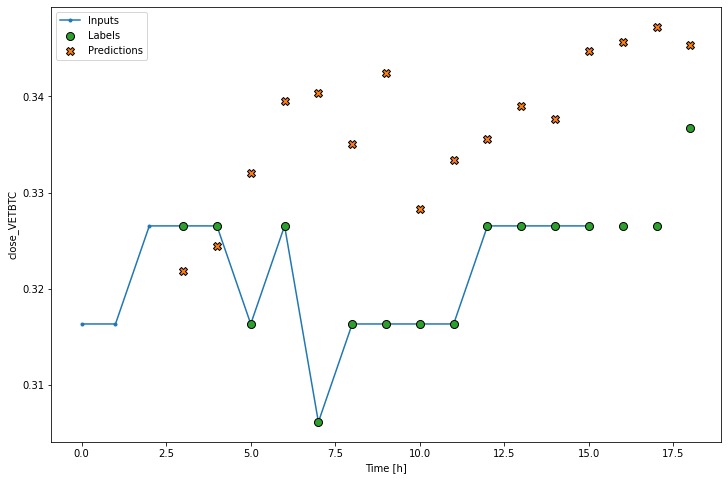

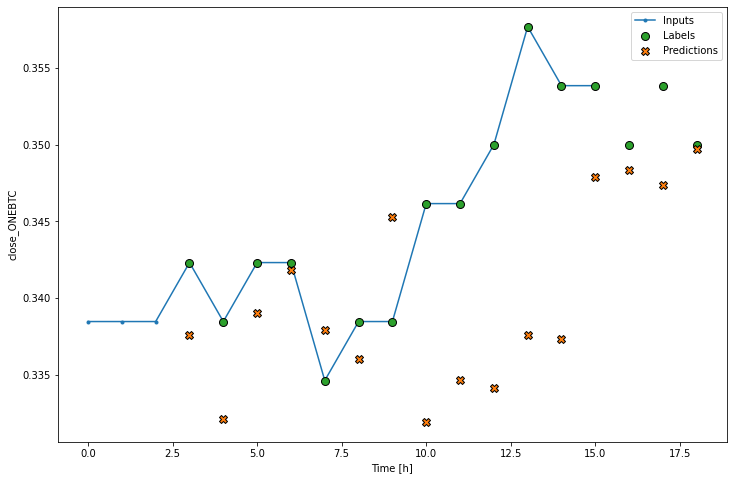

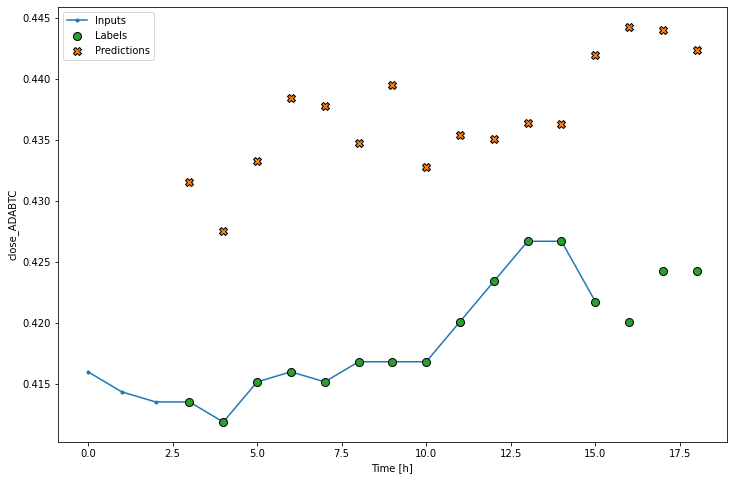

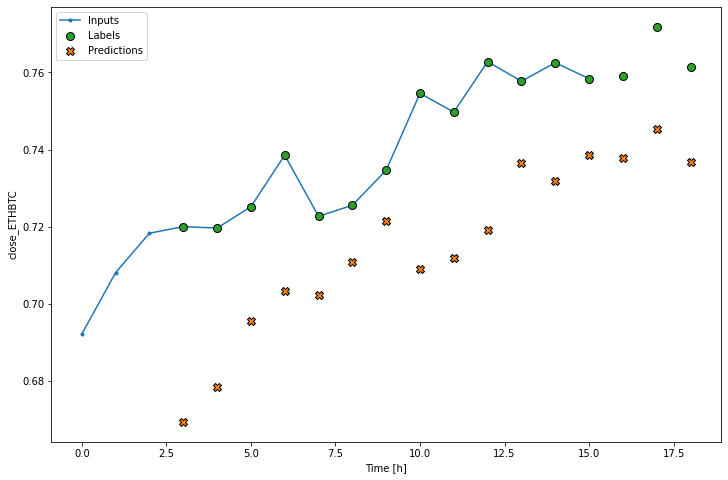

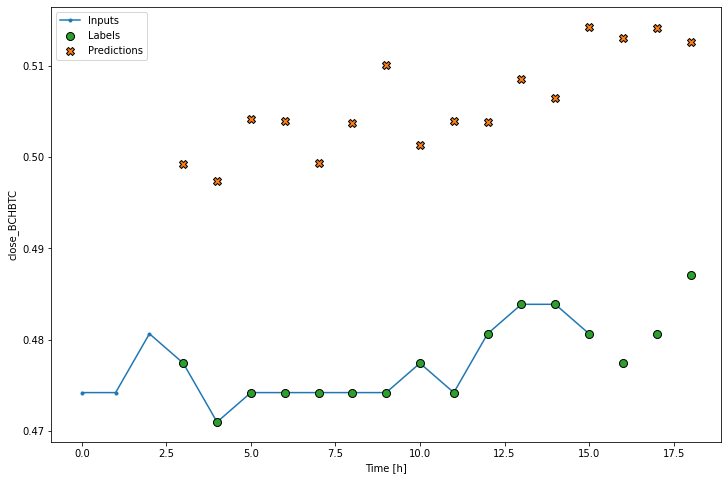

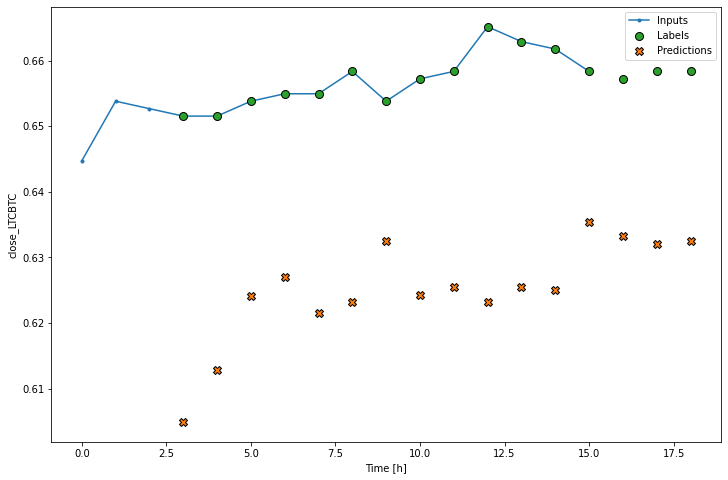

In [101]:
val_performance['model1'] = model1.evaluate(single_step_window.val)
performance['model1'] = model1.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model1, plot_col=i)

### Model 2: BEST INITIAL MODEL

In [102]:
model2 = Sequential()
model2.add(SimpleRNN(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(Dense(units=7))
history2 = compile_and_fit(model2, single_step_window)

Epoch 1/200
192/192 [==============================] - 2s 6ms/step - loss: 0.0443 - mean_absolute_error: 0.1389 - val_loss: 0.0040 - val_mean_absolute_error: 0.0437
Epoch 2/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0103 - mean_absolute_error: 0.0774 - val_loss: 0.0031 - val_mean_absolute_error: 0.0385
Epoch 3/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0075 - mean_absolute_error: 0.0660 - val_loss: 0.0027 - val_mean_absolute_error: 0.0375
Epoch 4/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0600 - val_loss: 0.0021 - val_mean_absolute_error: 0.0332
Epoch 5/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0051 - mean_absolute_error: 0.0548 - val_loss: 0.0020 - val_mean_absolute_error: 0.0322
Epoch 6/200
192/192 [==============================] - 1s 5ms/step - loss: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0020 - val_mean_absolute_error: 0.0333
Epoch 7/20

24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0302


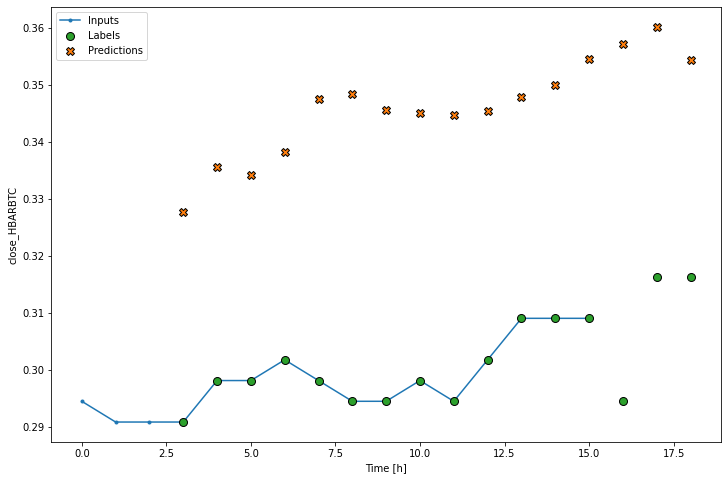

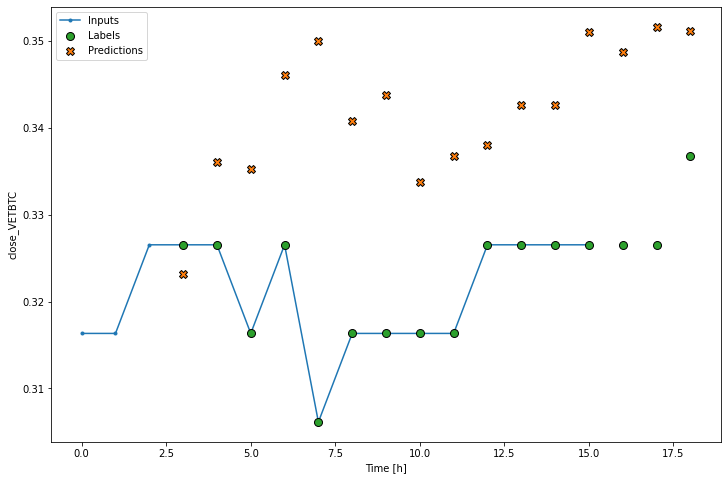

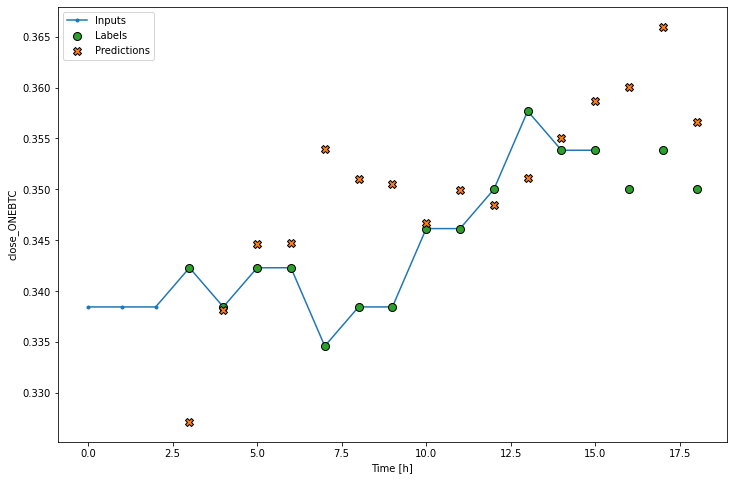

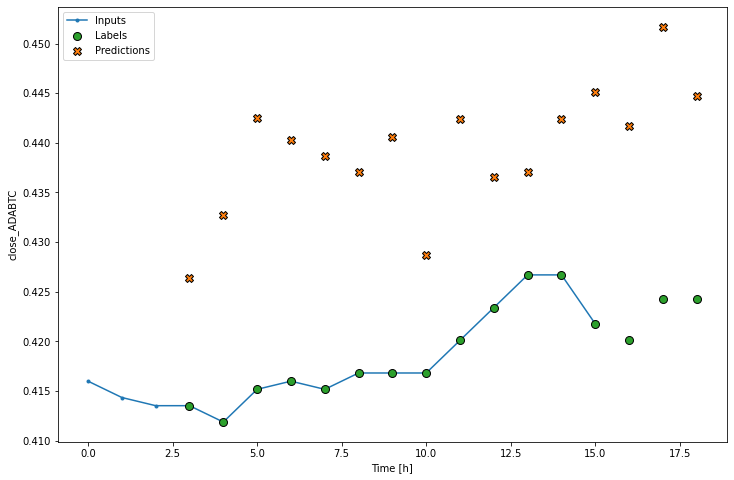

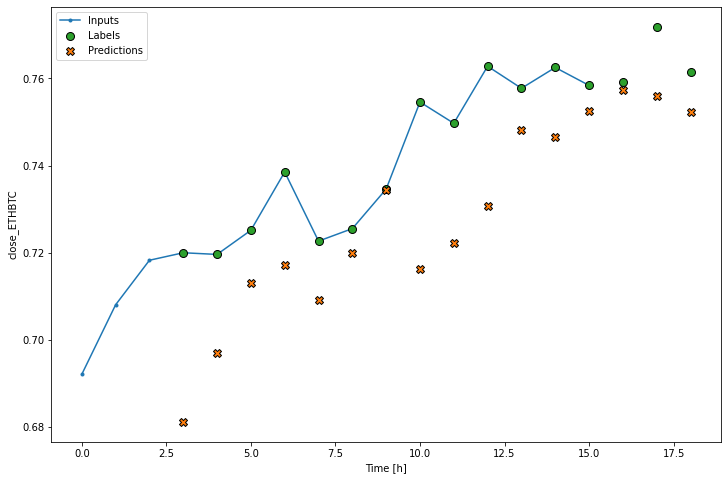

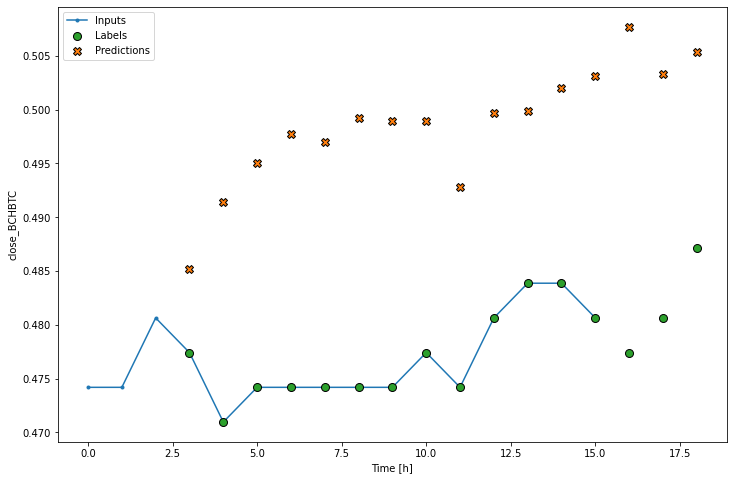

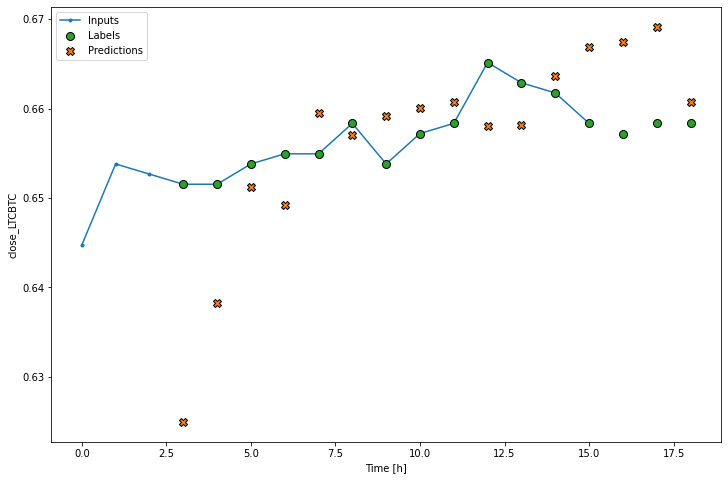

In [103]:
val_performance['model2'] = model2.evaluate(single_step_window.val)
performance['model2'] = model2.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model2, plot_col=i)

## Model Improvments - BEST MODEL

In [104]:
model3 = Sequential()
model3.add(Bidirectional(SimpleRNN(64, return_sequences=True), backward_layer=GRU(64, return_sequences=True, go_backwards=True)))
model3.add(Dropout(0.35))
model3.add(Dense(units=7))
history2 = compile_and_fit(model3, single_step_window)

Epoch 1/200
192/192 [==============================] - 4s 8ms/step - loss: 0.0256 - mean_absolute_error: 0.1036 - val_loss: 0.0015 - val_mean_absolute_error: 0.0297
Epoch 2/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0060 - mean_absolute_error: 0.0593 - val_loss: 0.0012 - val_mean_absolute_error: 0.0256
Epoch 3/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0509 - val_loss: 9.0717e-04 - val_mean_absolute_error: 0.0222
Epoch 4/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0468 - val_loss: 8.0602e-04 - val_mean_absolute_error: 0.0207
Epoch 5/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0443 - val_loss: 7.4187e-04 - val_mean_absolute_error: 0.0198
Epoch 6/200
192/192 [==============================] - 1s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 6.0929e-04 - val_mean_absolute_error: 0

24/24 [==============================] - 0s 3ms/step - loss: 4.8082e-04 - mean_absolute_error: 0.0165


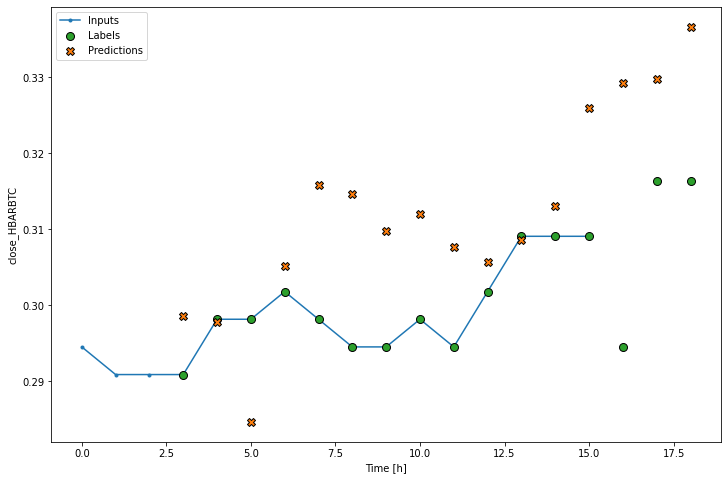

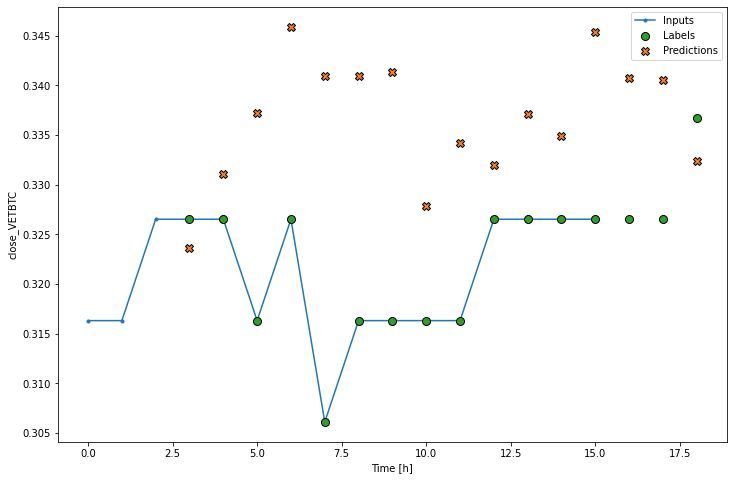

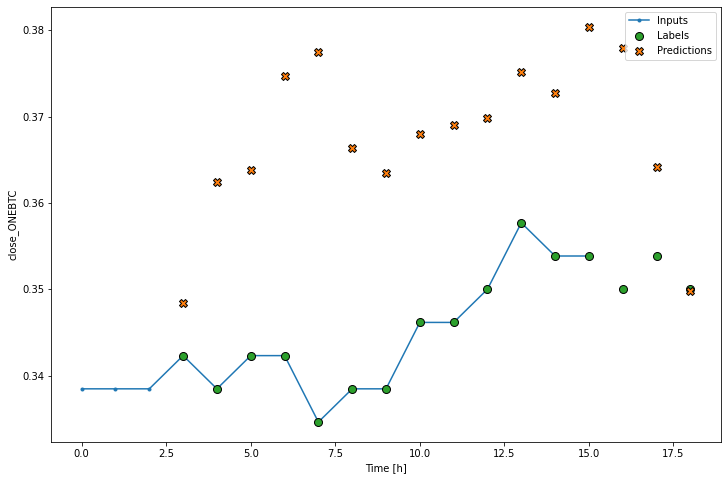

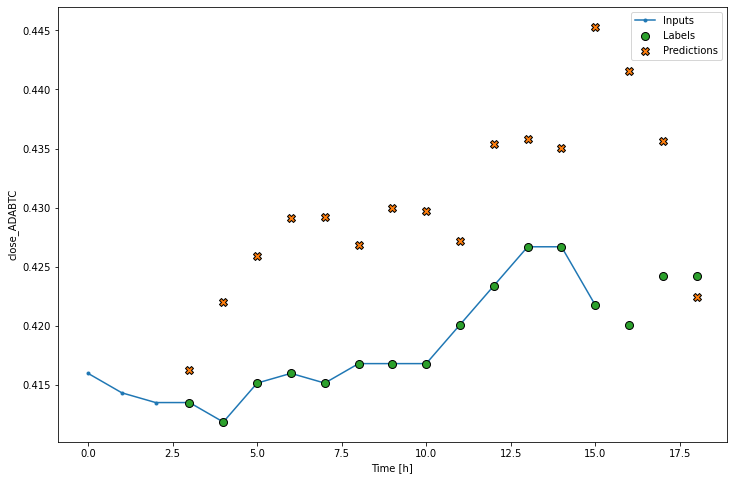

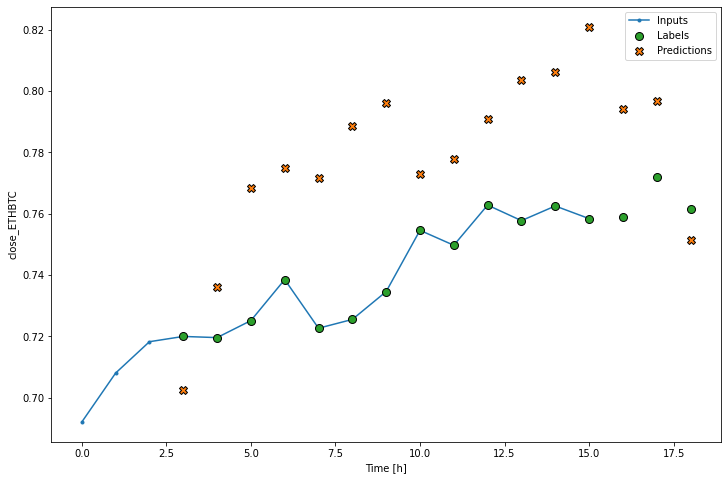

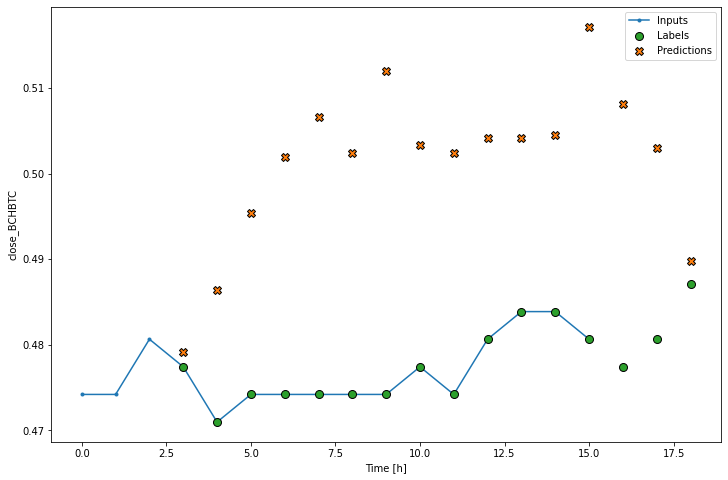

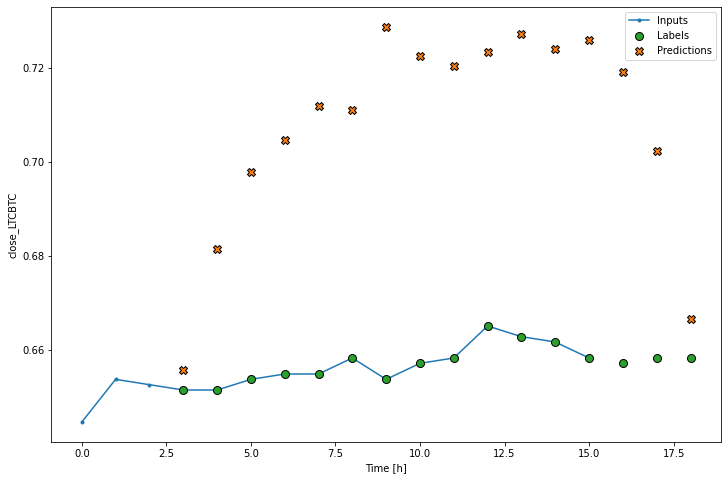

In [105]:
val_performance['model3'] = model3.evaluate(single_step_window.val)
performance['model3'] = model3.evaluate(single_step_window.test, verbose=0)
for i in list(y.columns):
  wide_window.plot(model3, plot_col=i)

# Save Model

In [428]:
# tf.keras.models.save_model(model3, './df_15_strat4_model')

INFO:tensorflow:Assets written to: ./df_15_strat4_model/assets


INFO:tensorflow:Assets written to: ./df_15_strat4_model/assets


# Testing Data Process

In [437]:
# # np.array([for i in range(1,149)])
# np.array([i for i in range(0,147)])


147

In [33]:
# list(test_df.columns) # order

['open_HBARBTC',
 'high_HBARBTC',
 'low_HBARBTC',
 'close_HBARBTC',
 'volume_HBARBTC',
 'sma_5_HBARBTC',
 'ema_18_HBARBTC',
 'ema_20_HBARBTC',
 'sma_50_HBARBTC',
 'sma_89_HBARBTC',
 'ema_144_HBARBTC',
 'ema_35_HBARBTC',
 'ku_HBARBTC',
 'a_HBARBTC',
 'b_HBARBTC',
 'c_HBARBTC',
 'rv_HBARBTC',
 'y_HBARBTC',
 'x_HBARBTC',
 'sl_HBARBTC',
 'ss_HBARBTC',
 'open_VETBTC',
 'high_VETBTC',
 'low_VETBTC',
 'close_VETBTC',
 'volume_VETBTC',
 'sma_5_VETBTC',
 'ema_18_VETBTC',
 'ema_20_VETBTC',
 'sma_50_VETBTC',
 'sma_89_VETBTC',
 'ema_144_VETBTC',
 'ema_35_VETBTC',
 'ku_VETBTC',
 'a_VETBTC',
 'b_VETBTC',
 'c_VETBTC',
 'rv_VETBTC',
 'y_VETBTC',
 'x_VETBTC',
 'sl_VETBTC',
 'ss_VETBTC',
 'open_ONEBTC',
 'high_ONEBTC',
 'low_ONEBTC',
 'close_ONEBTC',
 'volume_ONEBTC',
 'sma_5_ONEBTC',
 'ema_18_ONEBTC',
 'ema_20_ONEBTC',
 'sma_50_ONEBTC',
 'sma_89_ONEBTC',
 'ema_144_ONEBTC',
 'ema_35_ONEBTC',
 'ku_ONEBTC',
 'a_ONEBTC',
 'b_ONEBTC',
 'c_ONEBTC',
 'rv_ONEBTC',
 'y_ONEBTC',
 'x_ONEBTC',
 'sl_ONEBTC',
 'ss_O

In [34]:
# # ['ADABTC', 'ONEBTC', 'HBARBTC', 'VETBTC', 'LTCBTC', 'BCHBTC', 'ETHBTC']
# X_test_ADABTC_mean = get_columns_that_startwith(test_df, col_str='ADABTC').mean()
# X_test_ONEBTC_mean = get_columns_that_startwith(test_df, col_str='ONEBTC').mean()
# X_test_HBARBTC_mean = get_columns_that_startwith(test_df, col_str='HBARBTC').mean()
# X_test_VETBTC_mean = get_columns_that_startwith(test_df, col_str='VETBTC').mean()
# X_test_LTCBTC_mean = get_columns_that_startwith(test_df, col_str='LTCBTC').mean()
# X_test_BCHBTC_mean = get_columns_that_startwith(test_df, col_str='BCHBTC').mean()
# X_test_ETHBTC_mean = get_columns_that_startwith(test_df, col_str='ETHBTC').mean()
# X_test = np.array(list(X_test_HBARBTC_mean.values) + list(X_test_VETBTC_mean.values) + list(X_test_ONEBTC_mean.values) + list(X_test_ADABTC_mean.values) + list(X_test_ETHBTC_mean.values) + list(X_test_BCHBTC_mean.values) + list(X_test_LTCBTC_mean.values))
# X_test.reshape(())


In [48]:
# train_df_scal.shape

(1272, 147)

In [52]:
# np.reshape(X_test, (1, -1, 1))

array([[[5.18823899e-06],
        [5.18937107e-06],
        [5.18735849e-06],
        [5.18842767e-06],
        [3.68308176e+03],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [1.71207547e-06],
        [1.71440252e-06],
        [1.71075472e-06],
        [1.71295597e-06],
        [8.84257484e+04],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        [0.0

In [44]:
# model3.predict(tf.expand_dims(X_test, axis=0))

In [55]:
# model3.predict(np.reshape(X_test, (1, 1, -1)))

array([[[ 1.2818104 ,  0.155919  ,  0.08989048, -0.27423736,
         -0.3316908 ,  0.70417225,  0.9118595 ]]], dtype=float32)